In [1]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import math
import scipy.stats as stats
import itertools

In [2]:
# Load TMAS stock dataset
df_tmas = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='TMAS.JK')
df_tmas.set_index('Date', drop=True, inplace=True)
df_tmas.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,35799999,35799999,35799999,35799999,25929813,327500
2011-04-04,35400002,35400002,35200001,35400002,25640099,100000
2011-04-05,35200001,35200001,35000000,35200001,25495239,812500
2011-04-06,36000000,36000000,36000000,36000000,26074675,125000
2011-04-07,36000000,36000000,36000000,36000000,26074675,125000


In [3]:
# Check datatypes
print(df_tmas.dtypes)

Open         int64
High         int64
Low          int64
Close        int64
Adj Close    int64
Volume       int64
dtype: object


In [4]:
# Check missing value
print(df_tmas.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


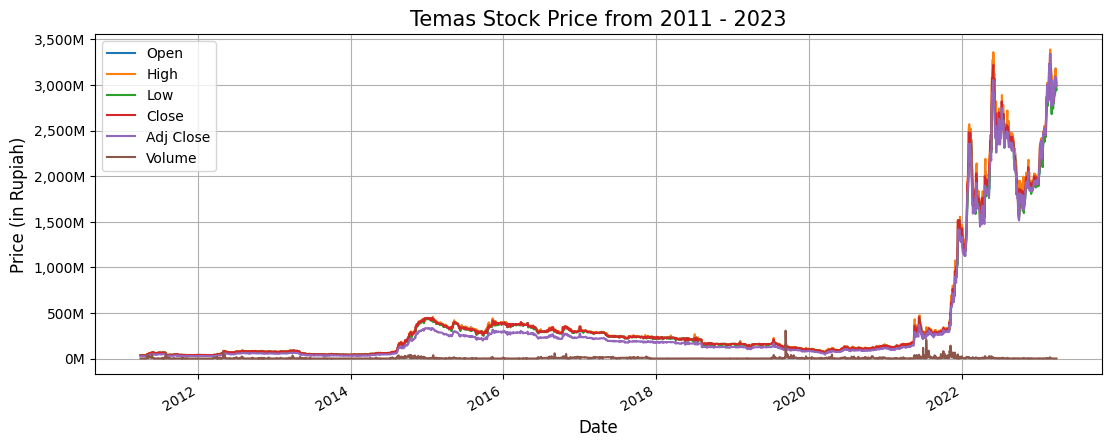

In [5]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_tmas.plot(figsize=(13,5))
plt.title('Temas Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [6]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_tmas[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [7]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.0010805 ]
 [0.00081037]
 [0.00067531]
 [0.00121556]
 [0.00121556]] 

Testing Scaled:  [[0.7906537 ]
 [0.77714749]
 [0.78052404]
 [0.78052404]
 [0.85818476]]


In [8]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [9]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 4s 57ms/step - loss: 0.0060 - val_loss: 0.0354
Epoch 2/10
24/24 [==============================] - 1s 26ms/step - loss: 7.9490e-04 - val_loss: 0.0134
Epoch 3/10
24/24 [==============================] - 1s 21ms/step - loss: 1.3359e-04 - val_loss: 0.0114
Epoch 4/10
24/24 [==============================] - 1s 21ms/step - loss: 1.2186e-04 - val_loss: 0.0095
Epoch 5/10
24/24 [==============================] - 1s 21ms/step - loss: 1.2374e-04 - val_loss: 0.0113
Epoch 6/10
24/24 [==============================] - 1s 21ms/step - loss: 1.0240e-04 - val_loss: 0.0105
Epoch 7/10
24/24 [==============================] - 1s 21ms/step - loss: 1.1978e-04 - val_loss: 0.0106
Epoch 8/10
24/24 [==============================] - 1s 21ms/step - loss: 9.3014e-05 - val_loss: 0.0090
Epoch 9/10
24/24 [==============================] - 1s 22ms/step - loss: 1.0888e-04 - val_loss: 0.0075
Epoch 10/10
24/24 [==============================] - 1s 22ms/step - loss: 1.0

In [10]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 7ms/step
Mean Absolute Error (MAE): 0.5825399
Mean Absolute Percentage Error (MAPE): 0.36527
Root Mean Squared Error (RMSE): 0.61982
Mean Squared Error (MSE): 0.3841733
R-Squared (R2): -3.518707
T-Statistic 0.937
P-Value 1.4029796879810874e-08
Elapsed Time (min): 9.56


7/7 [==============================] - 0s 6ms/step


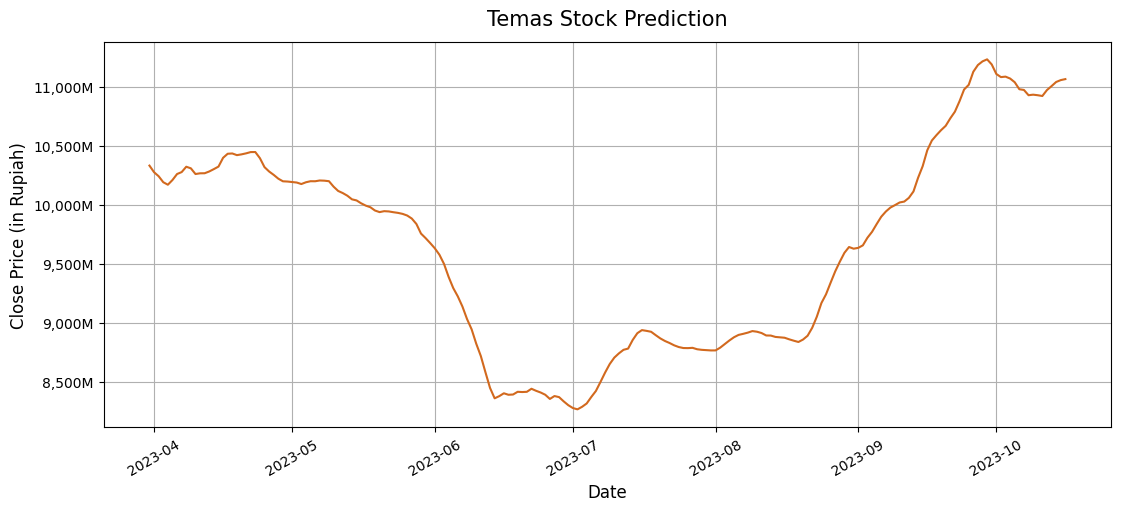

In [11]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [12]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 12s 238ms/step - loss: 0.0018 - val_loss: 0.0070
Epoch 2/10
24/24 [==============================] - 6s 253ms/step - loss: 2.2221e-04 - val_loss: 0.0056
Epoch 3/10
24/24 [==============================] - 6s 261ms/step - loss: 1.3957e-04 - val_loss: 0.0053
Epoch 4/10
24/24 [==============================] - 6s 268ms/step - loss: 1.3825e-04 - val_loss: 0.0047
Epoch 5/10
24/24 [==============================] - 7s 276ms/step - loss: 1.1196e-04 - val_loss: 0.0046
Epoch 6/10
24/24 [==============================] - 7s 282ms/step - loss: 1.2142e-04 - val_loss: 0.0039
Epoch 7/10
24/24 [==============================] - 7s 284ms/step - loss: 1.0994e-04 - val_loss: 0.0044
Epoch 8/10
24/24 [==============================] - 7s 298ms/step - loss: 1.0880e-04 - val_loss: 0.0037
Epoch 9/10
24/24 [==============================] - 7s 294ms/step - loss: 9.7653e-05 - val_loss: 0.0035
Epoch 10/10
24/24 [==============================] - 7s 298ms/step 

In [13]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 30ms/step
Mean Absolute Error (MAE): 0.1648907
Mean Absolute Percentage Error (MAPE): 0.10099
Root Mean Squared Error (RMSE): 0.20328
Mean Squared Error (MSE): 0.0413225
R-Squared (R2): 0.513958
T-Statistic 0.9437
P-Value 6.027016752341297e-08
Elapsed Time (min): 72.91


7/7 [==============================] - 0s 39ms/step


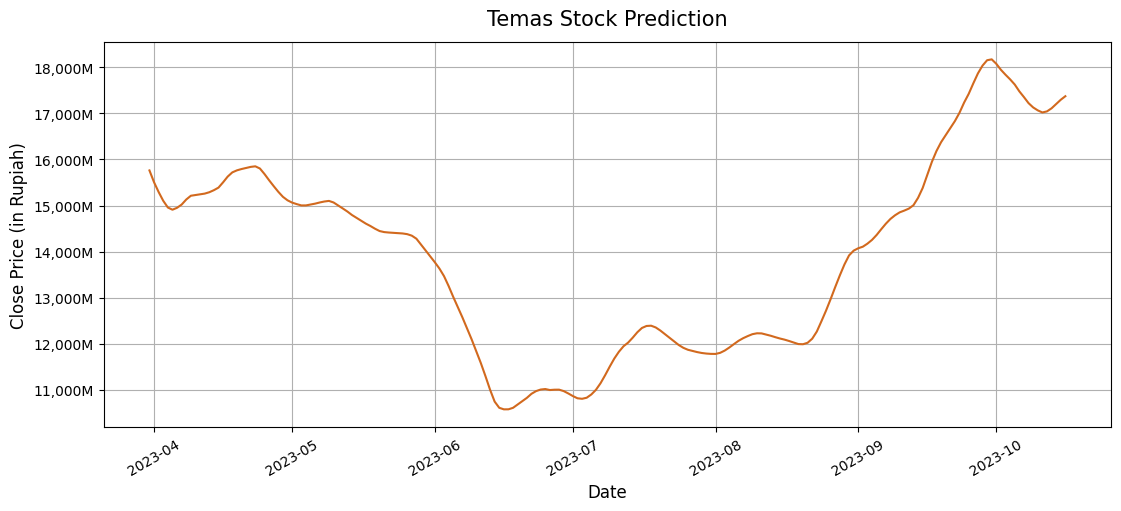

In [14]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [15]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 13s 275ms/step - loss: 0.0100 - val_loss: 0.0875
Epoch 2/10
24/24 [==============================] - 14s 579ms/step - loss: 0.0065 - val_loss: 0.0799
Epoch 3/10
24/24 [==============================] - 15s 620ms/step - loss: 0.0059 - val_loss: 0.0766
Epoch 4/10
24/24 [==============================] - 16s 650ms/step - loss: 0.0058 - val_loss: 0.0750
Epoch 5/10
24/24 [==============================] - 15s 606ms/step - loss: 0.0056 - val_loss: 0.0740
Epoch 6/10
24/24 [==============================] - 14s 582ms/step - loss: 0.0057 - val_loss: 0.0733
Epoch 7/10
24/24 [==============================] - 14s 602ms/step - loss: 0.0055 - val_loss: 0.0725
Epoch 8/10
24/24 [==============================] - 15s 607ms/step - loss: 0.0055 - val_loss: 0.0720
Epoch 9/10
24/24 [==============================] - 14s 595ms/step - loss: 0.0055 - val_loss: 0.0714
Epoch 10/10
24/24 [==============================] - 14s 601ms/step - loss: 0.0054 - val_lo

In [16]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 1.3594205
Mean Absolute Percentage Error (MAPE): 0.87749
Root Mean Squared Error (RMSE): 1.38841
Mean Squared Error (MSE): 1.9276772
R-Squared (R2): -21.673645
T-Statistic 0.9451
P-Value 8.3034812803362e-08
Elapsed Time (min): 144.38


7/7 [==============================] - 0s 36ms/step


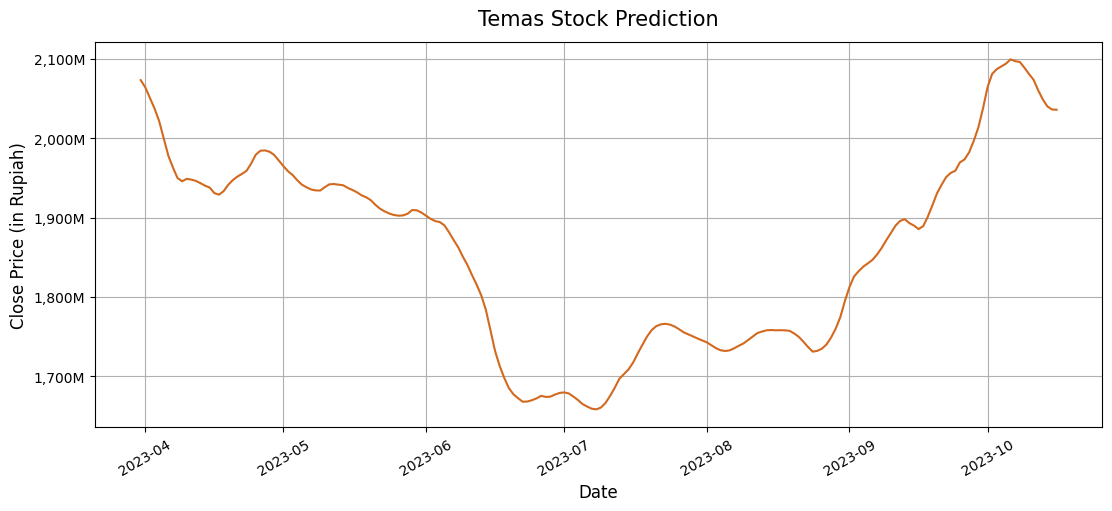

In [17]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [18]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 21s 564ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 2/10
24/24 [==============================] - 11s 442ms/step - loss: 2.1333e-04 - val_loss: 0.0054
Epoch 3/10
24/24 [==============================] - 10s 429ms/step - loss: 1.4410e-04 - val_loss: 0.0050
Epoch 4/10
24/24 [==============================] - 10s 405ms/step - loss: 1.4933e-04 - val_loss: 0.0046
Epoch 5/10
24/24 [==============================] - 9s 395ms/step - loss: 1.3110e-04 - val_loss: 0.0041
Epoch 6/10
24/24 [==============================] - 10s 416ms/step - loss: 1.2225e-04 - val_loss: 0.0037
Epoch 7/10
24/24 [==============================] - 10s 403ms/step - loss: 1.1528e-04 - val_loss: 0.0034
Epoch 8/10
24/24 [==============================] - 9s 388ms/step - loss: 9.6163e-05 - val_loss: 0.0034
Epoch 9/10
24/24 [==============================] - 11s 444ms/step - loss: 9.6852e-05 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 10s 433m

In [19]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 0.2766955
Mean Absolute Percentage Error (MAPE): 0.17442
Root Mean Squared Error (RMSE): 0.3052
Mean Squared Error (MSE): 0.0931482
R-Squared (R2): -0.095623
T-Statistic 0.9647
P-Value 1.2822457392758224e-05
Elapsed Time (min): 112.58


7/7 [==============================] - 0s 40ms/step


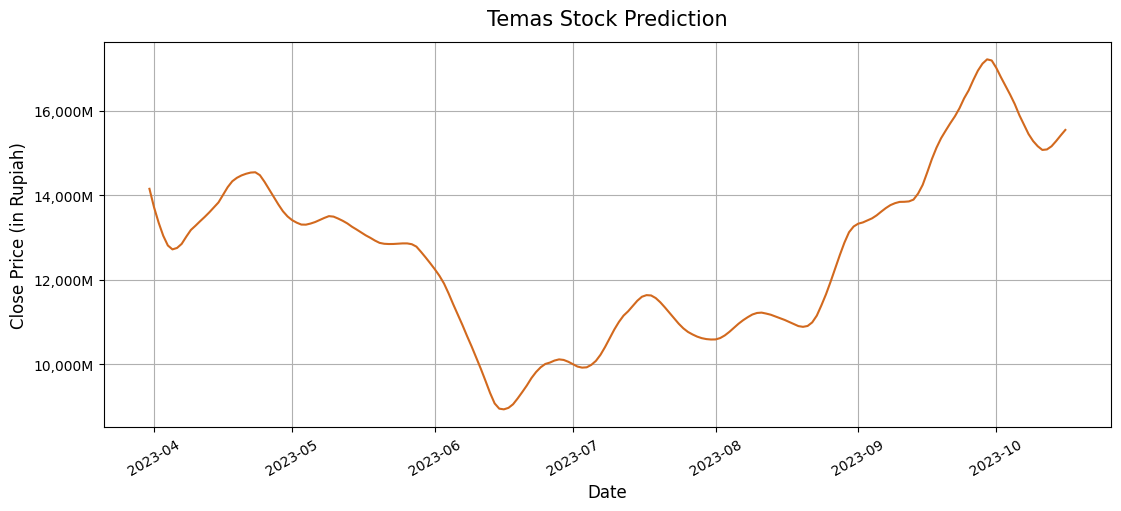

In [20]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [21]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 20s 578ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 2/10
24/24 [==============================] - 13s 527ms/step - loss: 6.0661e-04 - val_loss: 0.0066
Epoch 3/10
24/24 [==============================] - 12s 514ms/step - loss: 5.0269e-04 - val_loss: 0.0063
Epoch 4/10
24/24 [==============================] - 13s 555ms/step - loss: 4.8681e-04 - val_loss: 0.0068
Epoch 5/10
24/24 [==============================] - 13s 527ms/step - loss: 3.9956e-04 - val_loss: 0.0059
Epoch 6/10
24/24 [==============================] - 12s 505ms/step - loss: 4.2290e-04 - val_loss: 0.0055
Epoch 7/10
24/24 [==============================] - 13s 550ms/step - loss: 3.2966e-04 - val_loss: 0.0071
Epoch 8/10
24/24 [==============================] - 13s 540ms/step - loss: 3.8405e-04 - val_loss: 0.0059
Epoch 9/10
24/24 [==============================] - 13s 543ms/step - loss: 3.3902e-04 - val_loss: 0.0059
Epoch 10/10
24/24 [==============================] - 12s 49

In [22]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.377653
Mean Absolute Percentage Error (MAPE): 0.23375
Root Mean Squared Error (RMSE): 0.41669
Mean Squared Error (MSE): 0.1736341
R-Squared (R2): -1.042312
T-Statistic 0.9359
P-Value 1.1035983682461392e-08
Elapsed Time (min): 135.32


7/7 [==============================] - 0s 38ms/step


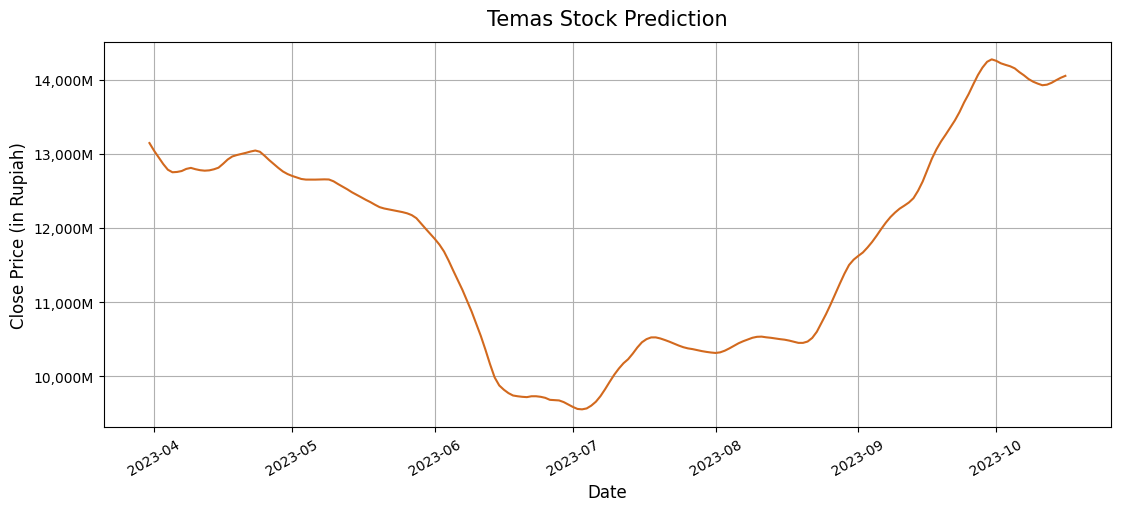

In [23]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [24]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 17s 442ms/step - loss: 0.0206 - val_loss: 0.1475
Epoch 2/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0204 - val_loss: 0.1463
Epoch 3/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0201 - val_loss: 0.1451
Epoch 4/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0196 - val_loss: 0.1439
Epoch 5/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0194 - val_loss: 0.1427
Epoch 6/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0190 - val_loss: 0.1414
Epoch 7/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0186 - val_loss: 0.1402
Epoch 8/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0184 - val_loss: 0.1390
Epoch 9/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0180 - val_loss: 0.1378
Epoch 10/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0177 - val_loss

In [25]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 1.6988036
Mean Absolute Percentage Error (MAPE): 1.10194
Root Mean Squared Error (RMSE): 1.7266
Mean Squared Error (MSE): 2.9811393
R-Squared (R2): -34.064634
T-Statistic 0.9352
P-Value 9.637939335505052e-09
Elapsed Time (min): 105.35


7/7 [==============================] - 0s 39ms/step


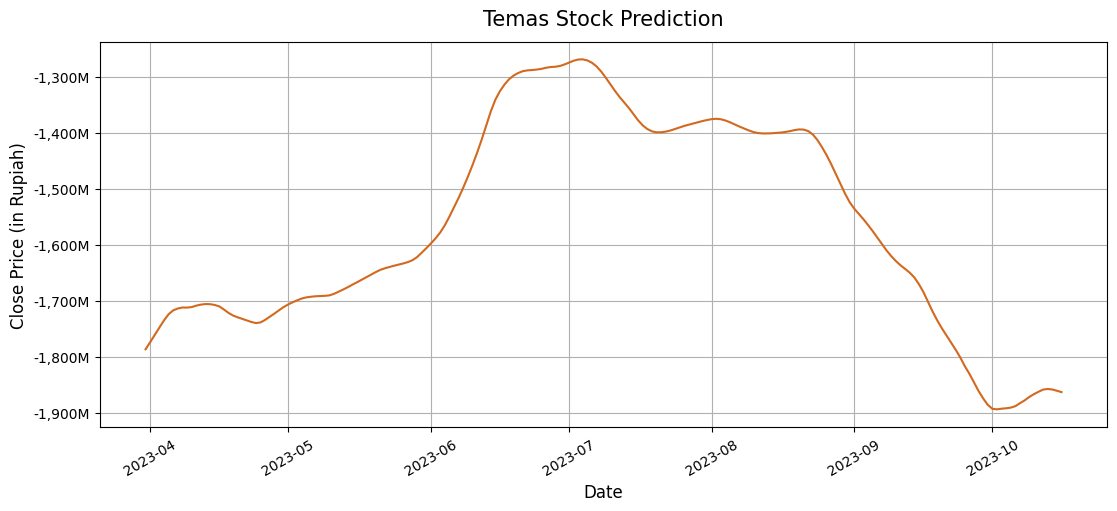

In [26]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [27]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 20s 559ms/step - loss: 0.0077 - val_loss: 0.0810
Epoch 2/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0061 - val_loss: 0.0787
Epoch 3/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0060 - val_loss: 0.0775
Epoch 4/10
24/24 [==============================] - 13s 527ms/step - loss: 0.0058 - val_loss: 0.0755
Epoch 5/10
24/24 [==============================] - 13s 559ms/step - loss: 0.0056 - val_loss: 0.0744
Epoch 6/10
24/24 [==============================] - 14s 568ms/step - loss: 0.0054 - val_loss: 0.0723
Epoch 7/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0053 - val_loss: 0.0704
Epoch 8/10
24/24 [==============================] - 13s 558ms/step - loss: 0.0052 - val_loss: 0.0689
Epoch 9/10
24/24 [==============================] - 14s 566ms/step - loss: 0.0050 - val_loss: 0.0685
Epoch 10/10
24/24 [==============================] - 14s 593ms/step - loss: 0.0049 - val_lo

In [28]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 46ms/step
Mean Absolute Error (MAE): 1.3045373
Mean Absolute Percentage Error (MAPE): 0.8415
Root Mean Squared Error (RMSE): 1.33331
Mean Squared Error (MSE): 1.7777032
R-Squared (R2): -19.909627
T-Statistic 0.9278
P-Value 2.1914896564112496e-09
Elapsed Time (min): 138.87


7/7 [==============================] - 0s 44ms/step


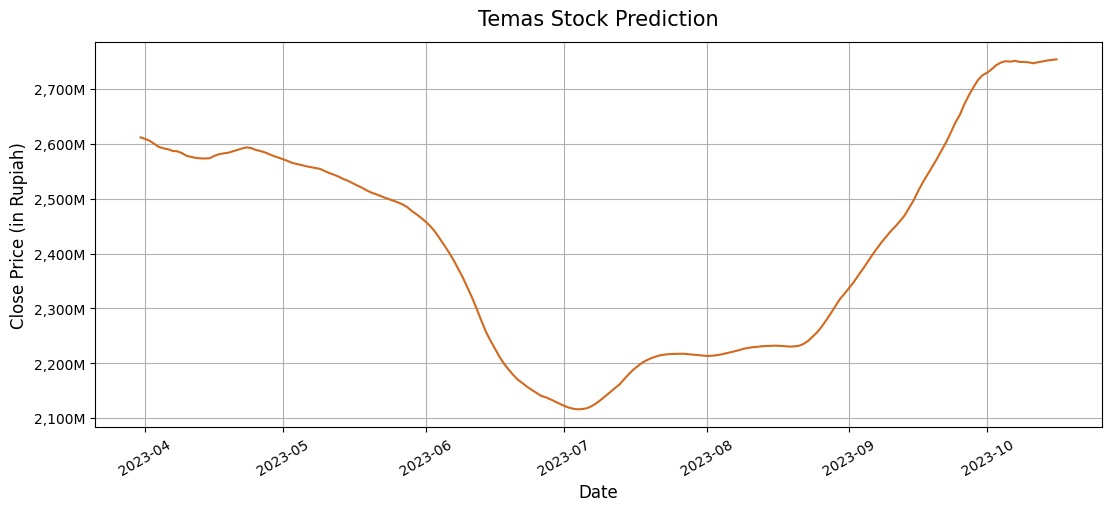

In [29]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [30]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 24s 674ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 2/10
24/24 [==============================] - 12s 488ms/step - loss: 2.9075e-04 - val_loss: 0.0066
Epoch 3/10
24/24 [==============================] - 11s 475ms/step - loss: 1.9481e-04 - val_loss: 0.0067
Epoch 4/10
24/24 [==============================] - 11s 469ms/step - loss: 1.8882e-04 - val_loss: 0.0063
Epoch 5/10
24/24 [==============================] - 13s 546ms/step - loss: 1.6244e-04 - val_loss: 0.0060
Epoch 6/10
24/24 [==============================] - 11s 453ms/step - loss: 1.6382e-04 - val_loss: 0.0059
Epoch 7/10
24/24 [==============================] - 11s 474ms/step - loss: 1.6587e-04 - val_loss: 0.0057
Epoch 8/10
24/24 [==============================] - 12s 486ms/step - loss: 1.5988e-04 - val_loss: 0.0056
Epoch 9/10
24/24 [==============================] - 11s 458ms/step - loss: 1.5553e-04 - val_loss: 0.0055
Epoch 10/10
24/24 [==============================] - 12s 48

In [31]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.1727892
Mean Absolute Percentage Error (MAPE): 0.10533
Root Mean Squared Error (RMSE): 0.21713
Mean Squared Error (MSE): 0.0471447
R-Squared (R2): 0.445476
T-Statistic 0.9385
P-Value 1.943722338637599e-08
Elapsed Time (min): 129.16


7/7 [==============================] - 0s 42ms/step


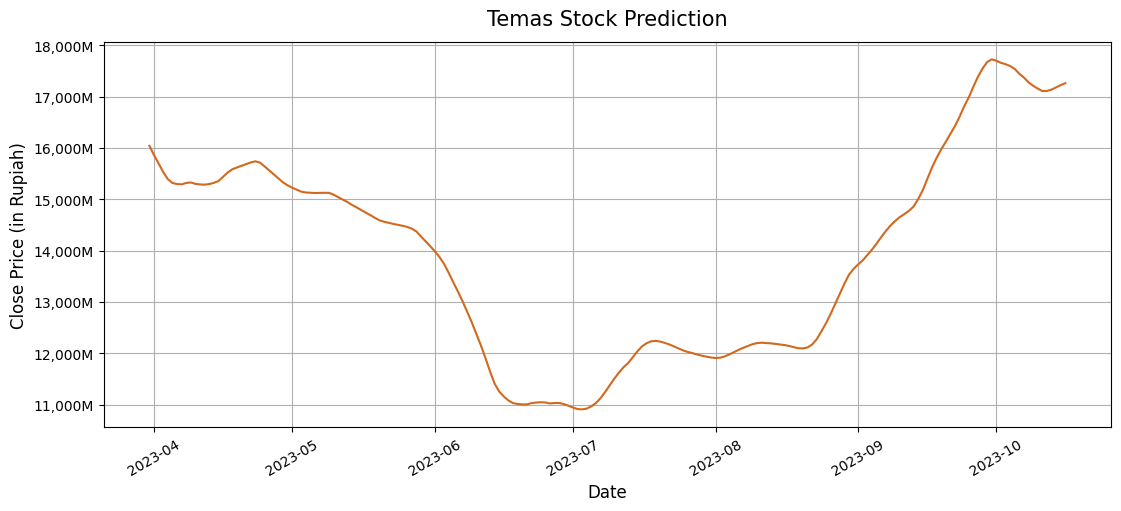

In [32]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [33]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 21s 564ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 2/10
24/24 [==============================] - 12s 498ms/step - loss: 2.3817e-04 - val_loss: 0.0056
Epoch 3/10
24/24 [==============================] - 12s 497ms/step - loss: 1.5730e-04 - val_loss: 0.0053
Epoch 4/10
24/24 [==============================] - 13s 525ms/step - loss: 1.4134e-04 - val_loss: 0.0059
Epoch 5/10
24/24 [==============================] - 13s 545ms/step - loss: 1.3847e-04 - val_loss: 0.0048
Epoch 6/10
24/24 [==============================] - 12s 514ms/step - loss: 1.3014e-04 - val_loss: 0.0046
Epoch 7/10
24/24 [==============================] - 13s 529ms/step - loss: 1.2097e-04 - val_loss: 0.0046
Epoch 8/10
24/24 [==============================] - 12s 511ms/step - loss: 1.1667e-04 - val_loss: 0.0043
Epoch 9/10
24/24 [==============================] - 13s 530ms/step - loss: 1.1446e-04 - val_loss: 0.0040
Epoch 10/10
24/24 [==============================] - 14s 56

In [34]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.2298114
Mean Absolute Percentage Error (MAPE): 0.14208
Root Mean Squared Error (RMSE): 0.26546
Mean Squared Error (MSE): 0.0704677
R-Squared (R2): 0.171148
T-Statistic 0.9466
P-Value 1.1832804602818214e-07
Elapsed Time (min): 135.15


7/7 [==============================] - 0s 43ms/step


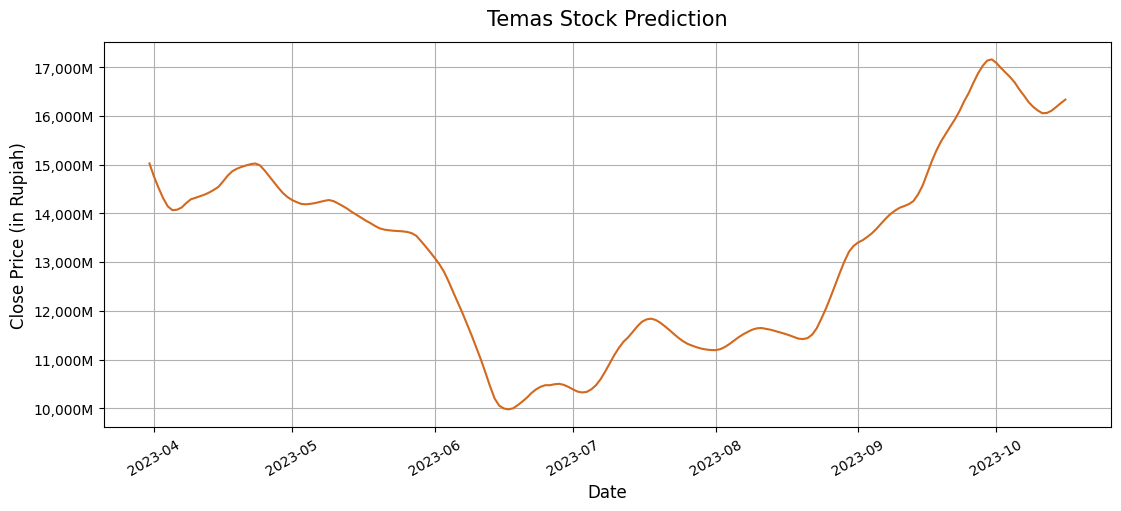

In [35]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [36]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 22s 663ms/step - loss: 0.0084 - val_loss: 0.0737
Epoch 2/10
24/24 [==============================] - 15s 632ms/step - loss: 0.0057 - val_loss: 0.0668
Epoch 3/10
24/24 [==============================] - 15s 607ms/step - loss: 0.0048 - val_loss: 0.0632
Epoch 4/10
24/24 [==============================] - 14s 586ms/step - loss: 0.0045 - val_loss: 0.0609
Epoch 5/10
24/24 [==============================] - 14s 571ms/step - loss: 0.0043 - val_loss: 0.0596
Epoch 6/10
24/24 [==============================] - 15s 609ms/step - loss: 0.0041 - val_loss: 0.0586
Epoch 7/10
24/24 [==============================] - 14s 583ms/step - loss: 0.0040 - val_loss: 0.0578
Epoch 8/10
24/24 [==============================] - 16s 663ms/step - loss: 0.0040 - val_loss: 0.0573
Epoch 9/10
24/24 [==============================] - 14s 578ms/step - loss: 0.0039 - val_loss: 0.0567
Epoch 10/10
24/24 [==============================] - 14s 594ms/step - loss: 0.0038 - val_lo

In [37]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 1.2031804
Mean Absolute Percentage Error (MAPE): 0.77573
Root Mean Squared Error (RMSE): 1.23052
Mean Squared Error (MSE): 1.5141695
R-Squared (R2): -16.809902
T-Statistic 0.9341
P-Value 7.703389925950432e-09
Elapsed Time (min): 153.03


7/7 [==============================] - 0s 39ms/step


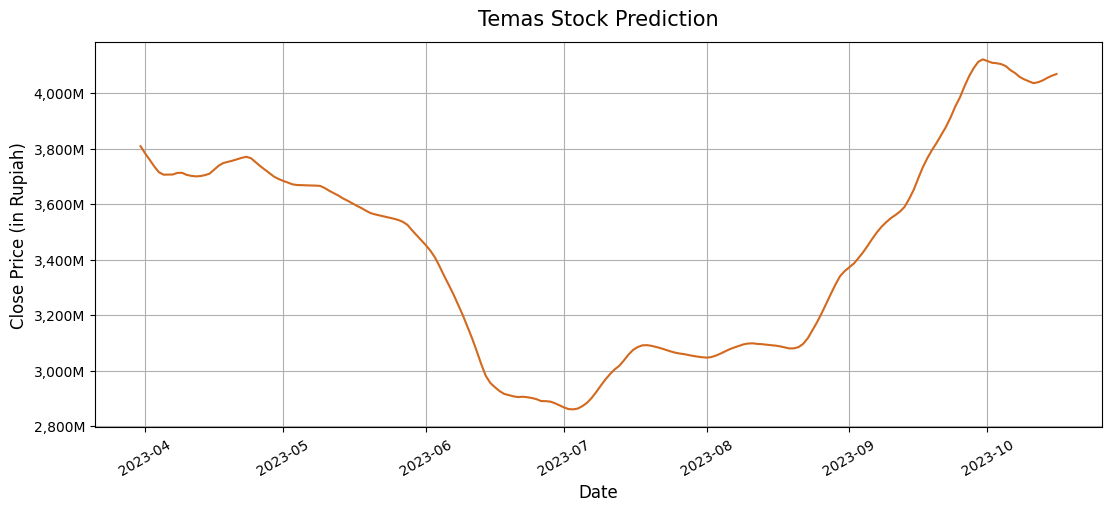

In [38]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [39]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 22s 584ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 2/10
24/24 [==============================] - 12s 513ms/step - loss: 2.0052e-04 - val_loss: 0.0068
Epoch 3/10
24/24 [==============================] - 12s 494ms/step - loss: 1.7233e-04 - val_loss: 0.0069
Epoch 4/10
24/24 [==============================] - 13s 529ms/step - loss: 1.4582e-04 - val_loss: 0.0060
Epoch 5/10
24/24 [==============================] - 13s 550ms/step - loss: 1.4383e-04 - val_loss: 0.0056
Epoch 6/10
24/24 [==============================] - 12s 505ms/step - loss: 1.3467e-04 - val_loss: 0.0049
Epoch 7/10
24/24 [==============================] - 13s 530ms/step - loss: 1.1466e-04 - val_loss: 0.0041
Epoch 8/10
24/24 [==============================] - 12s 508ms/step - loss: 1.1623e-04 - val_loss: 0.0046
Epoch 9/10
24/24 [==============================] - 12s 479ms/step - loss: 1.0963e-04 - val_loss: 0.0044
Epoch 10/10
24/24 [==============================] - 12s 48

In [40]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.2580699
Mean Absolute Percentage Error (MAPE): 0.16288
Root Mean Squared Error (RMSE): 0.2882
Mean Squared Error (MSE): 0.0830604
R-Squared (R2): 0.023031
T-Statistic 0.9577
P-Value 1.8372068097960437e-06
Elapsed Time (min): 133.87


7/7 [==============================] - 0s 44ms/step


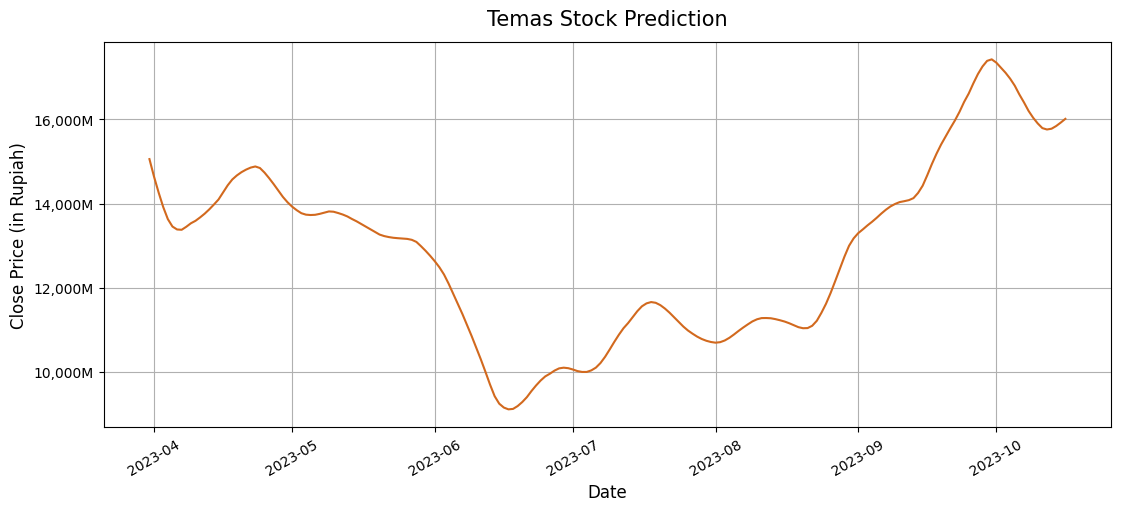

In [41]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [42]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 16s 371ms/step - loss: 0.0017 - val_loss: 0.0093
Epoch 2/10
24/24 [==============================] - 8s 318ms/step - loss: 6.0650e-04 - val_loss: 0.0086
Epoch 3/10
24/24 [==============================] - 8s 323ms/step - loss: 4.5888e-04 - val_loss: 0.0058
Epoch 4/10
24/24 [==============================] - 8s 321ms/step - loss: 4.1359e-04 - val_loss: 0.0066
Epoch 5/10
24/24 [==============================] - 8s 323ms/step - loss: 4.4085e-04 - val_loss: 0.0065
Epoch 6/10
24/24 [==============================] - 8s 331ms/step - loss: 3.4889e-04 - val_loss: 0.0061
Epoch 7/10
24/24 [==============================] - 8s 331ms/step - loss: 3.8297e-04 - val_loss: 0.0066
Epoch 8/10
24/24 [==============================] - 8s 322ms/step - loss: 2.9418e-04 - val_loss: 0.0064
Epoch 9/10
24/24 [==============================] - 8s 330ms/step - loss: 3.4984e-04 - val_loss: 0.0066
Epoch 10/10
24/24 [==============================] - 8s 342ms/step 

In [43]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.2983446
Mean Absolute Percentage Error (MAPE): 0.18196
Root Mean Squared Error (RMSE): 0.34276
Mean Squared Error (MSE): 0.1174824
R-Squared (R2): -0.381847
T-Statistic 0.9347
P-Value 8.646251714594655e-09
Elapsed Time (min): 87.05


7/7 [==============================] - 0s 38ms/step


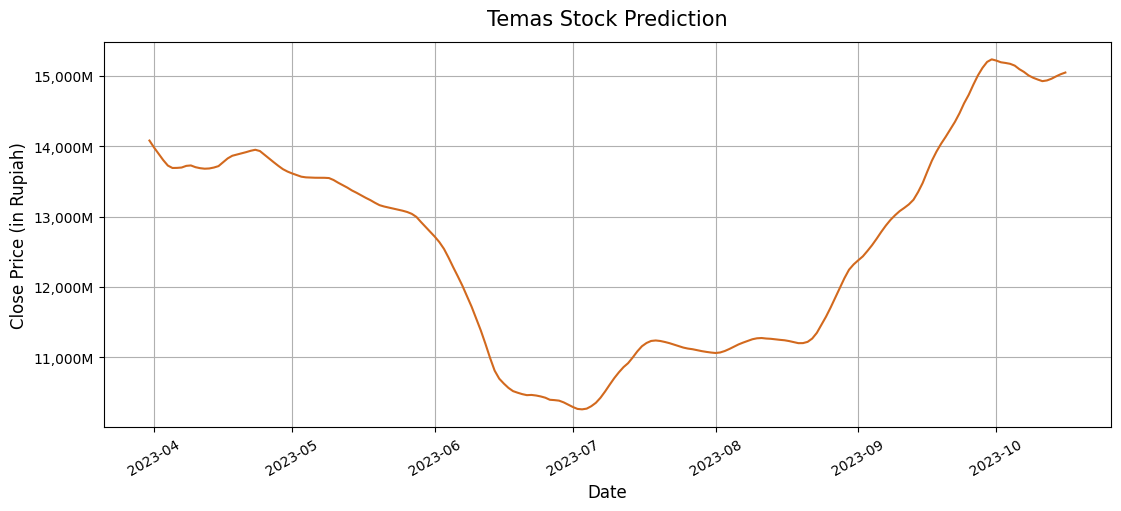

In [44]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [45]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 17s 369ms/step - loss: 0.0168 - val_loss: 0.1244
Epoch 2/10
24/24 [==============================] - 7s 301ms/step - loss: 0.0166 - val_loss: 0.1237
Epoch 3/10
24/24 [==============================] - 7s 301ms/step - loss: 0.0165 - val_loss: 0.1231
Epoch 4/10
24/24 [==============================] - 7s 307ms/step - loss: 0.0163 - val_loss: 0.1224
Epoch 5/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0162 - val_loss: 0.1218
Epoch 6/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0159 - val_loss: 0.1211
Epoch 7/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0157 - val_loss: 0.1205
Epoch 8/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0156 - val_loss: 0.1198
Epoch 9/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0154 - val_loss: 0.1192
Epoch 10/10
24/24 [==============================] - 9s 360ms/step - loss: 0.0152 - val_loss: 0.118

In [46]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 3s 55ms/step
Mean Absolute Error (MAE): 1.588086
Mean Absolute Percentage Error (MAPE): 1.02825
Root Mean Squared Error (RMSE): 1.61686
Mean Squared Error (MSE): 2.6142226
R-Squared (R2): -29.7489
T-Statistic 0.9449
P-Value 7.990795580781196e-08
Elapsed Time (min): 87.76


7/7 [==============================] - 0s 50ms/step


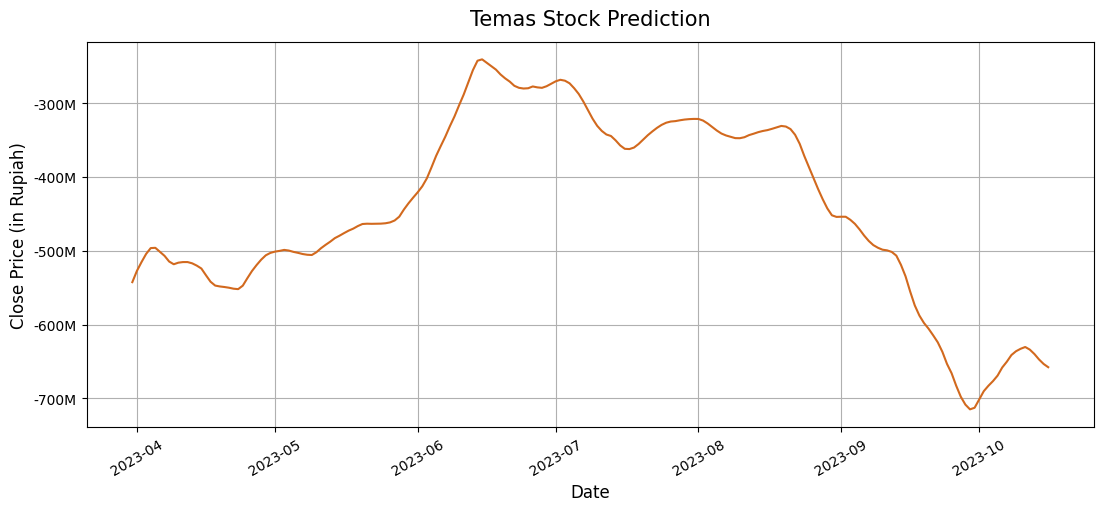

In [47]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [48]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 15s 375ms/step - loss: 0.0097 - val_loss: 0.0876
Epoch 2/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0058 - val_loss: 0.0800
Epoch 3/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0054 - val_loss: 0.0767
Epoch 4/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0052 - val_loss: 0.0753
Epoch 5/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0050 - val_loss: 0.0737
Epoch 6/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0050 - val_loss: 0.0730
Epoch 7/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0049 - val_loss: 0.0719
Epoch 8/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0048 - val_loss: 0.0707
Epoch 9/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0047 - val_loss: 0.0701
Epoch 10/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0046 - val_loss: 0.069

In [49]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 1.4147432
Mean Absolute Percentage Error (MAPE): 0.91228
Root Mean Squared Error (RMSE): 1.44631
Mean Squared Error (MSE): 2.091806
R-Squared (R2): -23.604154
T-Statistic 0.9297
P-Value 3.1617142237649887e-09
Elapsed Time (min): 72.64


7/7 [==============================] - 0s 36ms/step


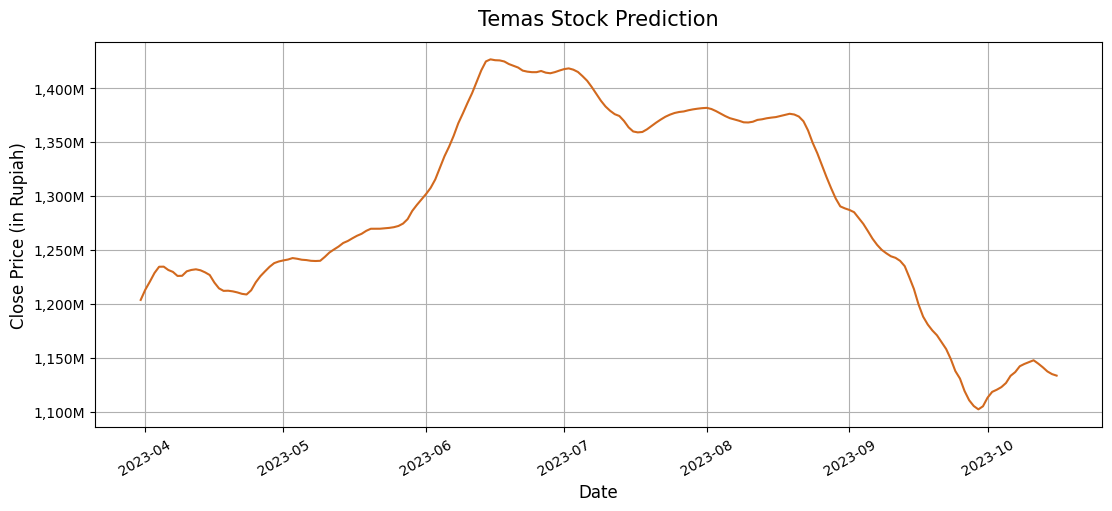

In [50]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [51]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 303ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 2/10
24/24 [==============================] - 6s 246ms/step - loss: 3.1764e-04 - val_loss: 0.0098
Epoch 3/10
24/24 [==============================] - 6s 260ms/step - loss: 2.3256e-04 - val_loss: 0.0083
Epoch 4/10
24/24 [==============================] - 6s 244ms/step - loss: 2.1321e-04 - val_loss: 0.0076
Epoch 5/10
24/24 [==============================] - 6s 249ms/step - loss: 1.9981e-04 - val_loss: 0.0081
Epoch 6/10
24/24 [==============================] - 6s 232ms/step - loss: 1.8875e-04 - val_loss: 0.0075
Epoch 7/10
24/24 [==============================] - 6s 239ms/step - loss: 1.8157e-04 - val_loss: 0.0076
Epoch 8/10
24/24 [==============================] - 6s 246ms/step - loss: 1.7450e-04 - val_loss: 0.0075
Epoch 9/10
24/24 [==============================] - 6s 242ms/step - loss: 1.7273e-04 - val_loss: 0.0072
Epoch 10/10
24/24 [==============================] - 6s 260ms/step 

In [52]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.1484958
Mean Absolute Percentage Error (MAPE): 0.09002
Root Mean Squared Error (RMSE): 0.20123
Mean Squared Error (MSE): 0.0404941
R-Squared (R2): 0.523703
T-Statistic 0.9372
P-Value 1.469133525944244e-08
Elapsed Time (min): 69.0


7/7 [==============================] - 0s 39ms/step


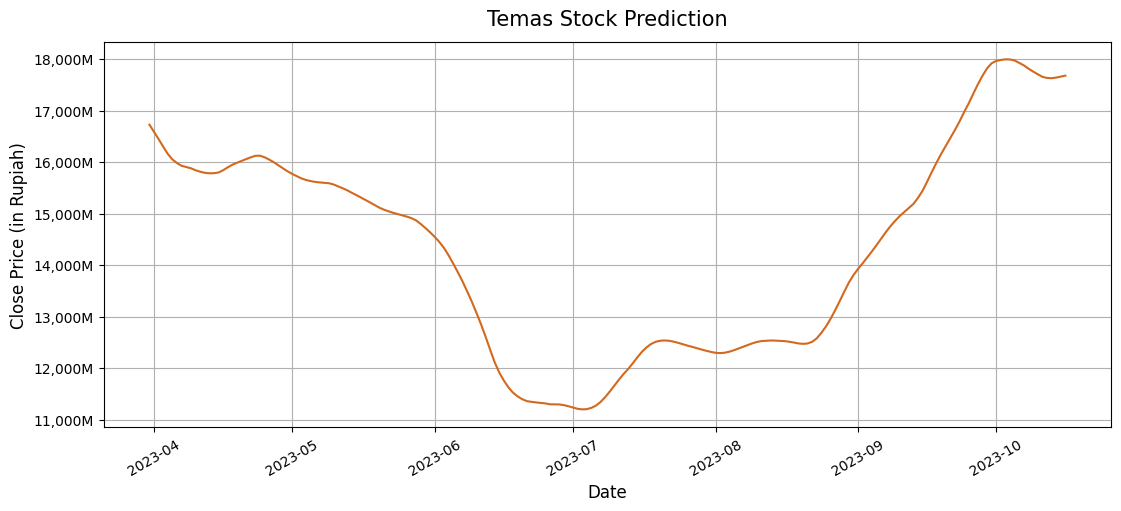

In [53]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [54]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 14s 274ms/step - loss: 0.3603 - val_loss: 0.1038
Epoch 2/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0152 - val_loss: 0.0804
Epoch 3/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0109 - val_loss: 0.0606
Epoch 4/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0072 - val_loss: 0.0422
Epoch 5/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0057 - val_loss: 0.0345
Epoch 6/10
24/24 [==============================] - 6s 230ms/step - loss: 0.0047 - val_loss: 0.0328
Epoch 7/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0044 - val_loss: 0.0306
Epoch 8/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0039 - val_loss: 0.0288
Epoch 9/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0035 - val_loss: 0.0300
Epoch 10/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0034 - val_loss: 0.028

In [55]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 1.0371461
Mean Absolute Percentage Error (MAPE): 0.6617
Root Mean Squared Error (RMSE): 1.07375
Mean Squared Error (MSE): 1.1529433
R-Squared (R2): -12.561101
T-Statistic 0.9244
P-Value 1.1303239455529024e-09
Elapsed Time (min): 63.9


7/7 [==============================] - 0s 40ms/step


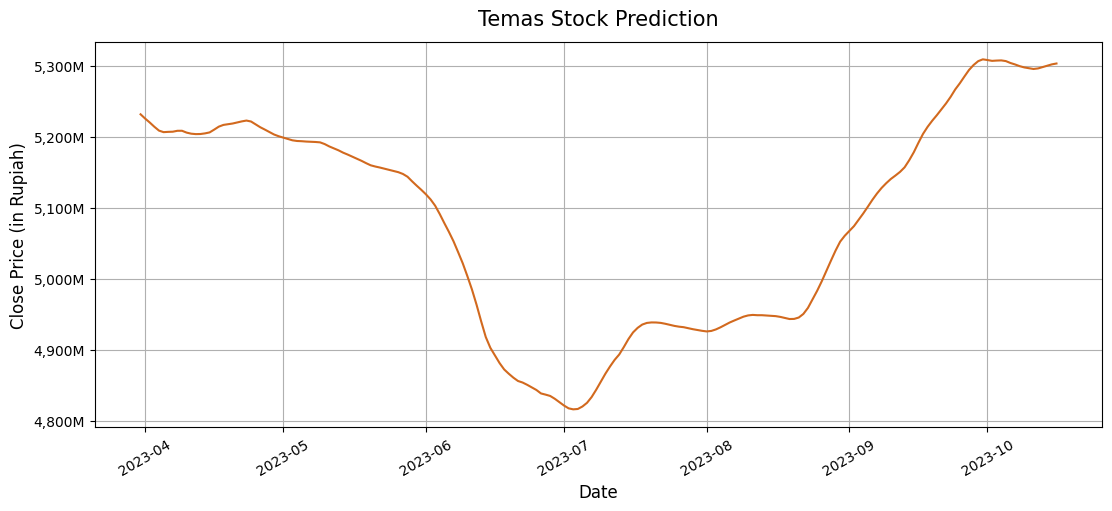

In [56]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [57]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 14s 305ms/step - loss: 0.3241 - val_loss: 0.4599
Epoch 2/10
24/24 [==============================] - 7s 271ms/step - loss: 0.2173 - val_loss: 0.3696
Epoch 3/10
24/24 [==============================] - 6s 261ms/step - loss: 0.1616 - val_loss: 0.3103
Epoch 4/10
24/24 [==============================] - 6s 259ms/step - loss: 0.1245 - val_loss: 0.2672
Epoch 5/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0982 - val_loss: 0.2342
Epoch 6/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0782 - val_loss: 0.2081
Epoch 7/10
24/24 [==============================] - 6s 255ms/step - loss: 0.0629 - val_loss: 0.1871
Epoch 8/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0511 - val_loss: 0.1698
Epoch 9/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0419 - val_loss: 0.1556
Epoch 10/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0346 - val_loss: 0.143

In [58]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 1.5624308
Mean Absolute Percentage Error (MAPE): 1.01335
Root Mean Squared Error (RMSE): 1.58824
Mean Squared Error (MSE): 2.5225199
R-Squared (R2): -28.670279
T-Statistic 0.9353
P-Value 9.896082175941956e-09
Elapsed Time (min): 70.78


7/7 [==============================] - 0s 44ms/step


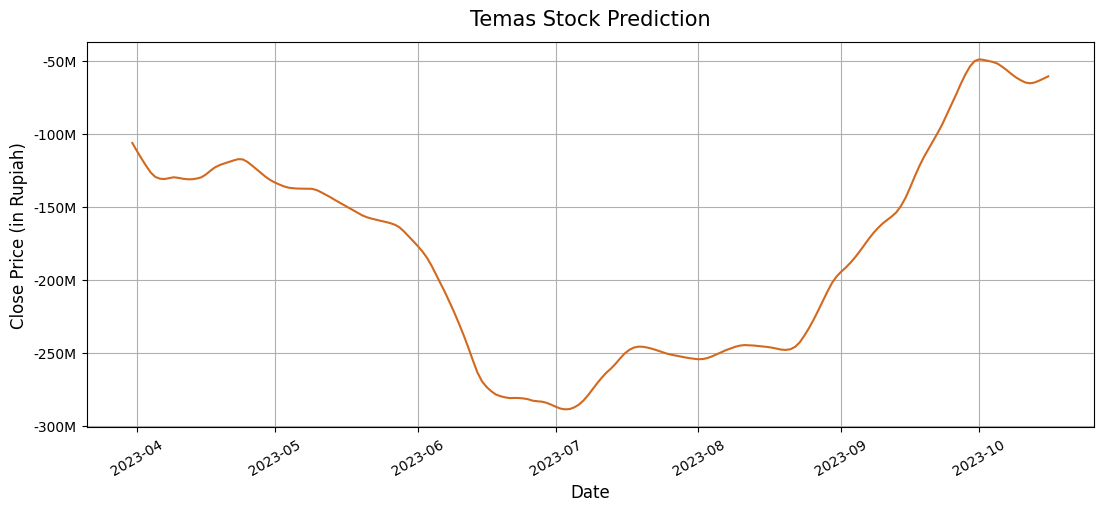

In [59]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [60]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 19s 395ms/step - loss: 0.2165 - val_loss: 0.0813
Epoch 2/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0093 - val_loss: 0.0818
Epoch 3/10
24/24 [==============================] - 8s 314ms/step - loss: 0.0048 - val_loss: 0.0456
Epoch 4/10
24/24 [==============================] - 7s 290ms/step - loss: 0.0028 - val_loss: 0.0458
Epoch 5/10
24/24 [==============================] - 8s 341ms/step - loss: 0.0025 - val_loss: 0.0516
Epoch 6/10
24/24 [==============================] - 7s 299ms/step - loss: 0.0021 - val_loss: 0.0475
Epoch 7/10
24/24 [==============================] - 7s 296ms/step - loss: 0.0019 - val_loss: 0.0466
Epoch 8/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0016 - val_loss: 0.0461
Epoch 9/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0015 - val_loss: 0.0498
Epoch 10/10
24/24 [==============================] - 7s 305ms/step - loss: 0.0013 - val_loss: 0.044

In [61]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 1.244571
Mean Absolute Percentage Error (MAPE): 0.79951
Root Mean Squared Error (RMSE): 1.27767
Mean Squared Error (MSE): 1.6324352
R-Squared (R2): -18.200962
T-Statistic 0.9218
P-Value 7.046140892974506e-10
Elapsed Time (min): 86.97


7/7 [==============================] - 0s 42ms/step


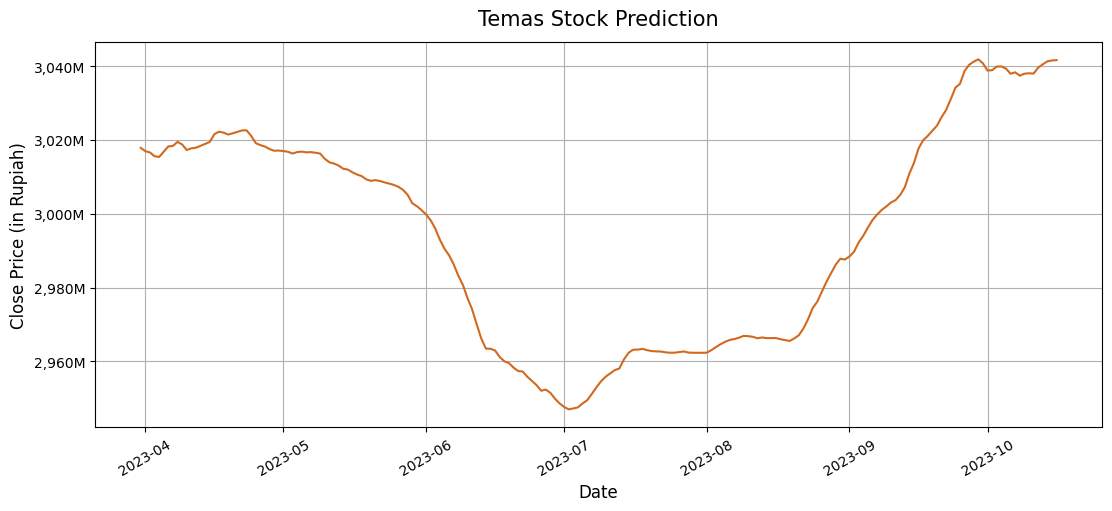

In [62]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [63]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 16s 348ms/step - loss: 0.0477 - val_loss: 0.0510
Epoch 2/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0055 - val_loss: 0.0389
Epoch 3/10
24/24 [==============================] - 8s 349ms/step - loss: 0.0051 - val_loss: 0.0483
Epoch 4/10
24/24 [==============================] - 7s 309ms/step - loss: 0.0034 - val_loss: 0.0429
Epoch 5/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0029 - val_loss: 0.0306
Epoch 6/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0022 - val_loss: 0.0282
Epoch 7/10
24/24 [==============================] - 8s 328ms/step - loss: 0.0013 - val_loss: 0.0230
Epoch 8/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0014 - val_loss: 0.0308
Epoch 9/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0012 - val_loss: 0.0228
Epoch 10/10
24/24 [==============================] - 8s 317ms/step - loss: 8.9059e-04 - val_loss: 0

In [64]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.9123407
Mean Absolute Percentage Error (MAPE): 0.57994
Root Mean Squared Error (RMSE): 0.94942
Mean Squared Error (MSE): 0.9013942
R-Squared (R2): -9.602341
T-Statistic 0.9308
P-Value 3.929979897066005e-09
Elapsed Time (min): 84.29


7/7 [==============================] - 0s 42ms/step


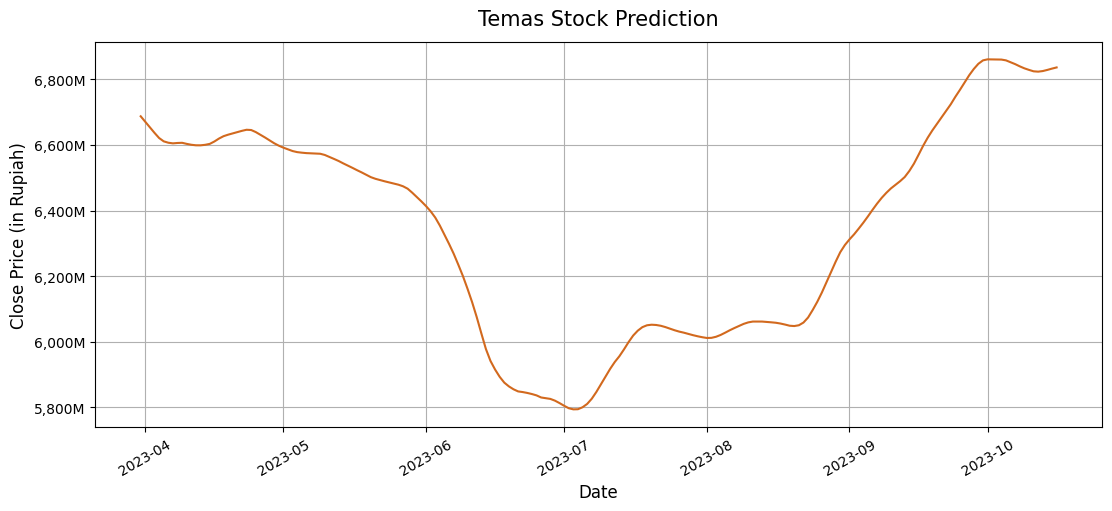

In [65]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [66]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 16s 356ms/step - loss: 0.2723 - val_loss: 0.4905
Epoch 2/10
24/24 [==============================] - 7s 295ms/step - loss: 0.2714 - val_loss: 0.4891
Epoch 3/10
24/24 [==============================] - 7s 301ms/step - loss: 0.2704 - val_loss: 0.4876
Epoch 4/10
24/24 [==============================] - 7s 291ms/step - loss: 0.2692 - val_loss: 0.4861
Epoch 5/10
24/24 [==============================] - 7s 297ms/step - loss: 0.2682 - val_loss: 0.4845
Epoch 6/10
24/24 [==============================] - 7s 305ms/step - loss: 0.2670 - val_loss: 0.4829
Epoch 7/10
24/24 [==============================] - 7s 289ms/step - loss: 0.2660 - val_loss: 0.4814
Epoch 8/10
24/24 [==============================] - 7s 298ms/step - loss: 0.2648 - val_loss: 0.4797
Epoch 9/10
24/24 [==============================] - 7s 282ms/step - loss: 0.2638 - val_loss: 0.4781
Epoch 10/10
24/24 [==============================] - 7s 295ms/step - loss: 0.2626 - val_loss: 0.476

In [67]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 1.9527325
Mean Absolute Percentage Error (MAPE): 1.27434
Root Mean Squared Error (RMSE): 1.97461
Mean Squared Error (MSE): 3.8990916
R-Squared (R2): -44.861733
T-Statistic 0.9595
P-Value 2.978614702442428e-06
Elapsed Time (min): 81.14


7/7 [==============================] - 0s 40ms/step


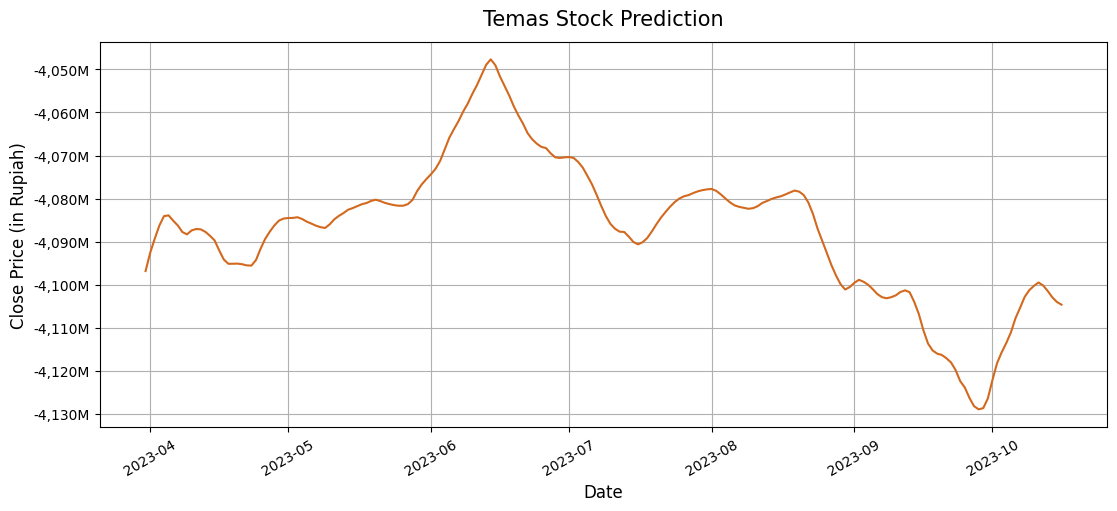

In [68]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [69]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 15s 370ms/step - loss: 0.0107 - val_loss: 0.0779
Epoch 2/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0059 - val_loss: 0.0774
Epoch 3/10
24/24 [==============================] - 8s 313ms/step - loss: 0.0059 - val_loss: 0.0762
Epoch 4/10
24/24 [==============================] - 8s 331ms/step - loss: 0.0059 - val_loss: 0.0766
Epoch 5/10
24/24 [==============================] - 8s 316ms/step - loss: 0.0059 - val_loss: 0.0779
Epoch 6/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0059 - val_loss: 0.0768
Epoch 7/10
24/24 [==============================] - 8s 322ms/step - loss: 0.0059 - val_loss: 0.0764
Epoch 8/10
24/24 [==============================] - 7s 310ms/step - loss: 0.0059 - val_loss: 0.0761
Epoch 9/10
24/24 [==============================] - 8s 340ms/step - loss: 0.0059 - val_loss: 0.0770
Epoch 10/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0059 - val_loss: 0.075

In [70]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 1.4164581
Mean Absolute Percentage Error (MAPE): 0.91503
Root Mean Squared Error (RMSE): 1.4454
Mean Squared Error (MSE): 2.0891936
R-Squared (R2): -23.573427
T-Statistic 0.9335
P-Value 6.767773008675704e-09
Elapsed Time (min): 85.25


7/7 [==============================] - 0s 42ms/step


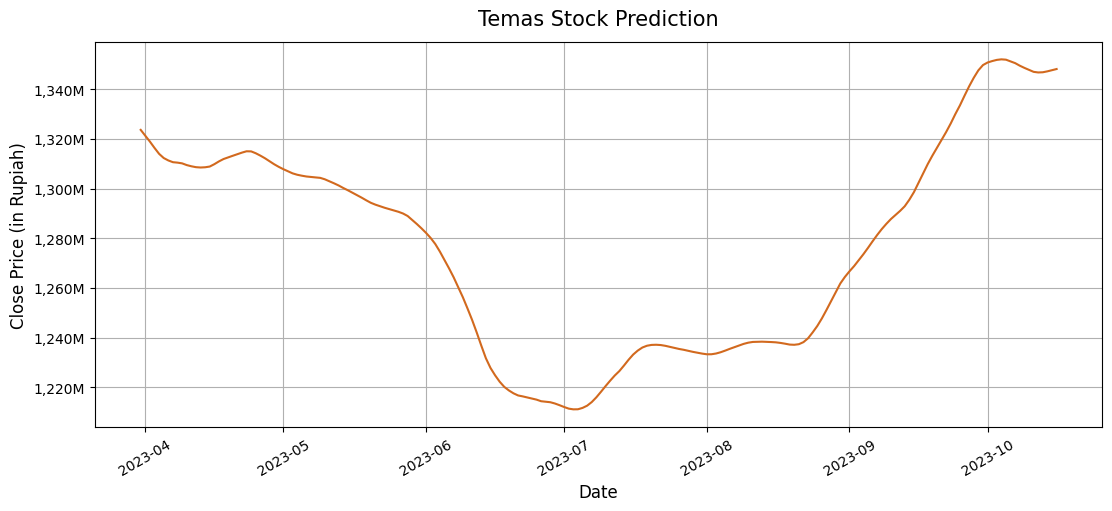

In [71]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [72]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 16s 380ms/step - loss: 0.2522 - val_loss: 0.1107
Epoch 2/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0204 - val_loss: 0.1050
Epoch 3/10
24/24 [==============================] - 7s 299ms/step - loss: 0.0136 - val_loss: 0.0883
Epoch 4/10
24/24 [==============================] - 7s 306ms/step - loss: 0.0116 - val_loss: 0.0765
Epoch 5/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0079 - val_loss: 0.0508
Epoch 6/10
24/24 [==============================] - 7s 311ms/step - loss: 0.0054 - val_loss: 0.0491
Epoch 7/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0045 - val_loss: 0.0472
Epoch 8/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0042 - val_loss: 0.0462
Epoch 9/10
24/24 [==============================] - 7s 298ms/step - loss: 0.0039 - val_loss: 0.0460
Epoch 10/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0037 - val_loss: 0.044

In [73]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 1.2344657
Mean Absolute Percentage Error (MAPE): 0.7924
Root Mean Squared Error (RMSE): 1.26841
Mean Squared Error (MSE): 1.6088571
R-Squared (R2): -17.923633
T-Statistic 0.9816
P-Value 0.0035539325326681137
Elapsed Time (min): 83.94


7/7 [==============================] - 0s 44ms/step


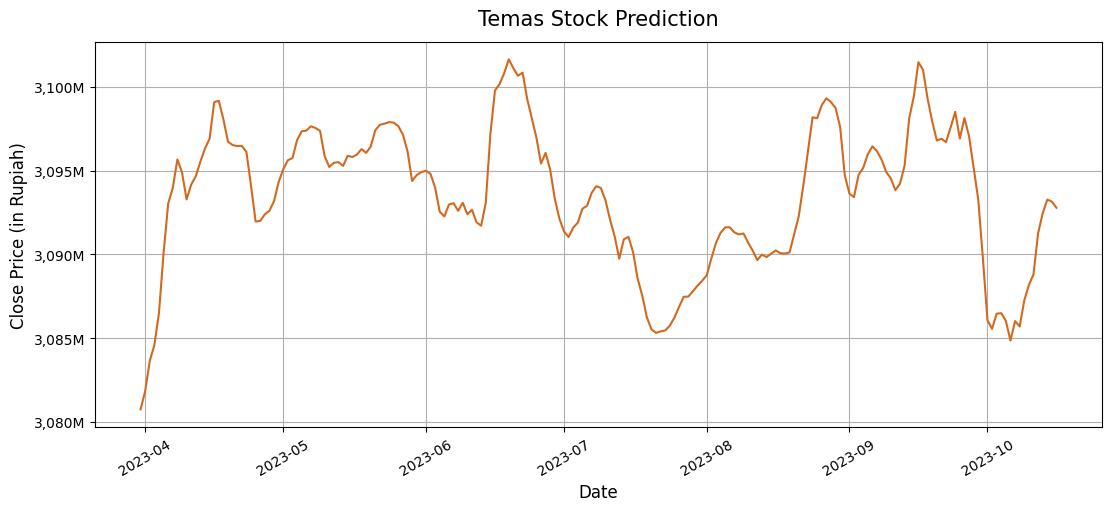

In [74]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [75]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 16s 354ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 2/10
24/24 [==============================] - 7s 285ms/step - loss: 2.1264e-04 - val_loss: 0.0057
Epoch 3/10
24/24 [==============================] - 7s 295ms/step - loss: 1.4275e-04 - val_loss: 0.0048
Epoch 4/10
24/24 [==============================] - 7s 307ms/step - loss: 1.2587e-04 - val_loss: 0.0051
Epoch 5/10
24/24 [==============================] - 8s 322ms/step - loss: 1.1561e-04 - val_loss: 0.0044
Epoch 6/10
24/24 [==============================] - 7s 293ms/step - loss: 1.1027e-04 - val_loss: 0.0045
Epoch 7/10
24/24 [==============================] - 7s 309ms/step - loss: 1.1933e-04 - val_loss: 0.0040
Epoch 8/10
24/24 [==============================] - 8s 335ms/step - loss: 1.1218e-04 - val_loss: 0.0038
Epoch 9/10
24/24 [==============================] - 8s 339ms/step - loss: 9.9821e-05 - val_loss: 0.0036
Epoch 10/10
24/24 [==============================] - 9s 361ms/step 

In [76]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Error (MAE): 0.2635969
Mean Absolute Percentage Error (MAPE): 0.16299
Root Mean Squared Error (RMSE): 0.29769
Mean Squared Error (MSE): 0.088622
R-Squared (R2): -0.042387
T-Statistic 0.9483
P-Value 1.765994994684661e-07
Elapsed Time (min): 84.72


7/7 [==============================] - 0s 52ms/step


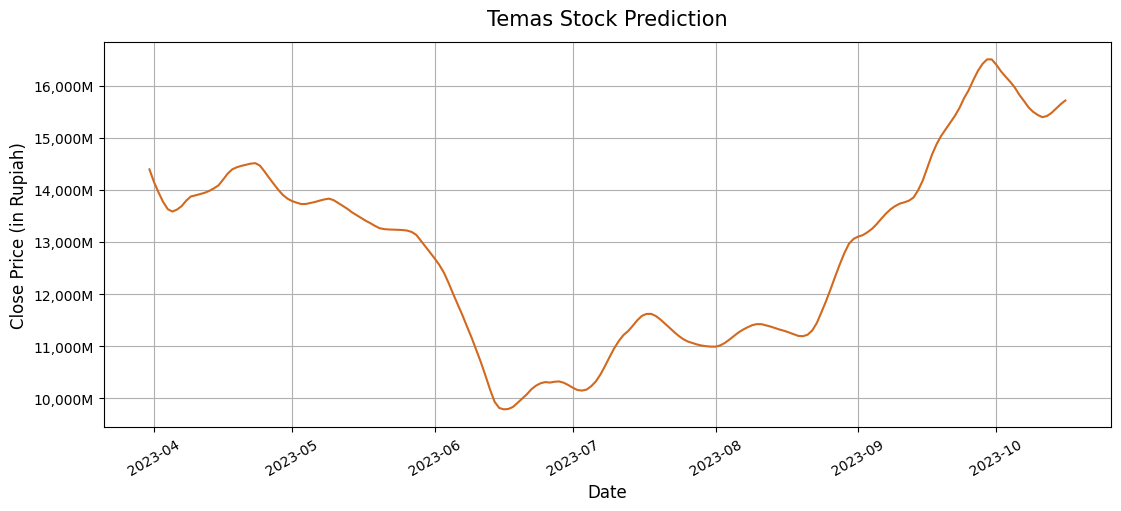

In [77]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [78]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 317ms/step - loss: 0.0098 - val_loss: 0.0868
Epoch 2/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0064 - val_loss: 0.0798
Epoch 3/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0060 - val_loss: 0.0772
Epoch 4/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0058 - val_loss: 0.0763
Epoch 5/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0059 - val_loss: 0.0755
Epoch 6/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0058 - val_loss: 0.0748
Epoch 7/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0057 - val_loss: 0.0743
Epoch 8/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0057 - val_loss: 0.0738
Epoch 9/10
24/24 [==============================] - 5s 225ms/step - loss: 0.0056 - val_loss: 0.0733
Epoch 10/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0056 - val_loss: 0.072

In [79]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 35ms/step
Mean Absolute Error (MAE): 1.3858043
Mean Absolute Percentage Error (MAPE): 0.89492
Root Mean Squared Error (RMSE): 1.41466
Mean Squared Error (MSE): 2.0012696
R-Squared (R2): -22.539251
T-Statistic 0.9447
P-Value 7.594238837782541e-08
Elapsed Time (min): 68.79


7/7 [==============================] - 0s 37ms/step


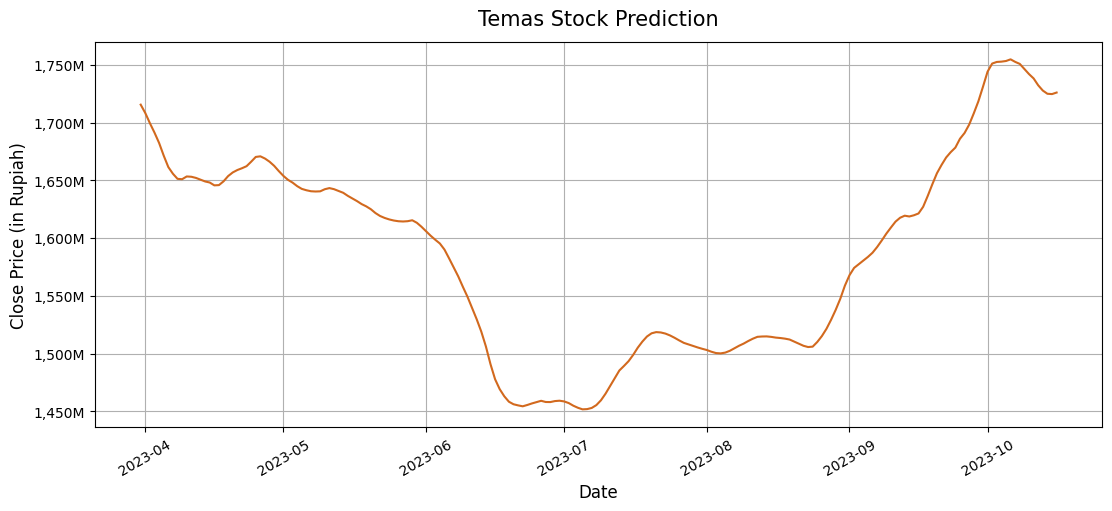

In [80]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [81]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 16s 284ms/step - loss: 0.0020 - val_loss: 0.0064
Epoch 2/10
24/24 [==============================] - 5s 207ms/step - loss: 1.7021e-04 - val_loss: 0.0053
Epoch 3/10
24/24 [==============================] - 5s 209ms/step - loss: 1.4866e-04 - val_loss: 0.0045
Epoch 4/10
24/24 [==============================] - 5s 211ms/step - loss: 1.2616e-04 - val_loss: 0.0040
Epoch 5/10
24/24 [==============================] - 5s 212ms/step - loss: 1.2284e-04 - val_loss: 0.0039
Epoch 6/10
24/24 [==============================] - 5s 210ms/step - loss: 1.1531e-04 - val_loss: 0.0037
Epoch 7/10
24/24 [==============================] - 5s 213ms/step - loss: 1.1916e-04 - val_loss: 0.0038
Epoch 8/10
24/24 [==============================] - 5s 224ms/step - loss: 1.0282e-04 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 5s 220ms/step - loss: 9.6630e-05 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 5s 223ms/step 

In [82]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.267067
Mean Absolute Percentage Error (MAPE): 0.16604
Root Mean Squared Error (RMSE): 0.29935
Mean Squared Error (MSE): 0.089608
R-Squared (R2): -0.053984
T-Statistic 0.9643
P-Value 1.1495571015984751e-05
Elapsed Time (min): 63.25


7/7 [==============================] - 0s 36ms/step


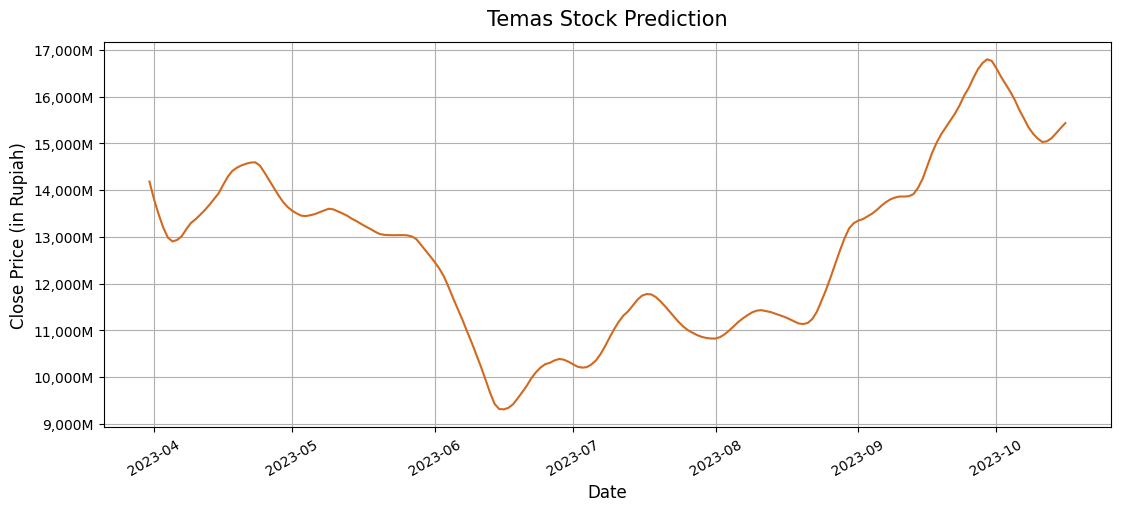

In [83]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [84]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 14s 289ms/step - loss: 0.0018 - val_loss: 0.0227
Epoch 2/10
24/24 [==============================] - 5s 221ms/step - loss: 7.6348e-04 - val_loss: 0.0111
Epoch 3/10
24/24 [==============================] - 5s 218ms/step - loss: 4.6187e-04 - val_loss: 0.0140
Epoch 4/10
24/24 [==============================] - 5s 219ms/step - loss: 5.6945e-04 - val_loss: 0.0113
Epoch 5/10
24/24 [==============================] - 5s 220ms/step - loss: 5.4422e-04 - val_loss: 0.0101
Epoch 6/10
24/24 [==============================] - 6s 236ms/step - loss: 4.7280e-04 - val_loss: 0.0108
Epoch 7/10
24/24 [==============================] - 5s 228ms/step - loss: 3.6708e-04 - val_loss: 0.0119
Epoch 8/10
24/24 [==============================] - 6s 254ms/step - loss: 4.2417e-04 - val_loss: 0.0098
Epoch 9/10
24/24 [==============================] - 6s 240ms/step - loss: 3.4499e-04 - val_loss: 0.0080
Epoch 10/10
24/24 [==============================] - 6s 251ms/step 

In [85]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.3675875
Mean Absolute Percentage Error (MAPE): 0.22508
Root Mean Squared Error (RMSE): 0.41339
Mean Squared Error (MSE): 0.170889
R-Squared (R2): -1.010024
T-Statistic 0.9342
P-Value 7.907805965601256e-09
Elapsed Time (min): 65.1


7/7 [==============================] - 0s 47ms/step


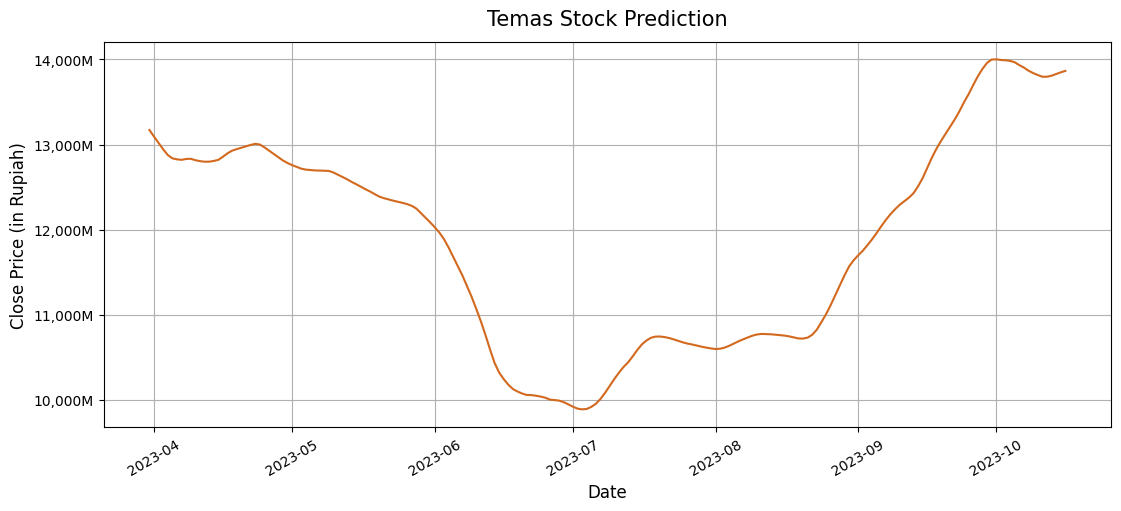

In [86]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [87]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 14s 276ms/step - loss: 0.0131 - val_loss: 0.0996
Epoch 2/10
24/24 [==============================] - 5s 199ms/step - loss: 0.0129 - val_loss: 0.0989
Epoch 3/10
24/24 [==============================] - 5s 205ms/step - loss: 0.0126 - val_loss: 0.0981
Epoch 4/10
24/24 [==============================] - 5s 206ms/step - loss: 0.0124 - val_loss: 0.0974
Epoch 5/10
24/24 [==============================] - 5s 206ms/step - loss: 0.0122 - val_loss: 0.0967
Epoch 6/10
24/24 [==============================] - 5s 210ms/step - loss: 0.0121 - val_loss: 0.0959
Epoch 7/10
24/24 [==============================] - 5s 216ms/step - loss: 0.0118 - val_loss: 0.0952
Epoch 8/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0115 - val_loss: 0.0944
Epoch 9/10
24/24 [==============================] - 5s 211ms/step - loss: 0.0114 - val_loss: 0.0937
Epoch 10/10
24/24 [==============================] - 5s 217ms/step - loss: 0.0112 - val_loss: 0.093

In [88]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 1.399788
Mean Absolute Percentage Error (MAPE): 0.90569
Root Mean Squared Error (RMSE): 1.42622
Mean Squared Error (MSE): 2.0341072
R-Squared (R2): -22.925492
T-Statistic 0.9374
P-Value 1.5290968491399326e-08
Elapsed Time (min): 61.05


7/7 [==============================] - 0s 37ms/step


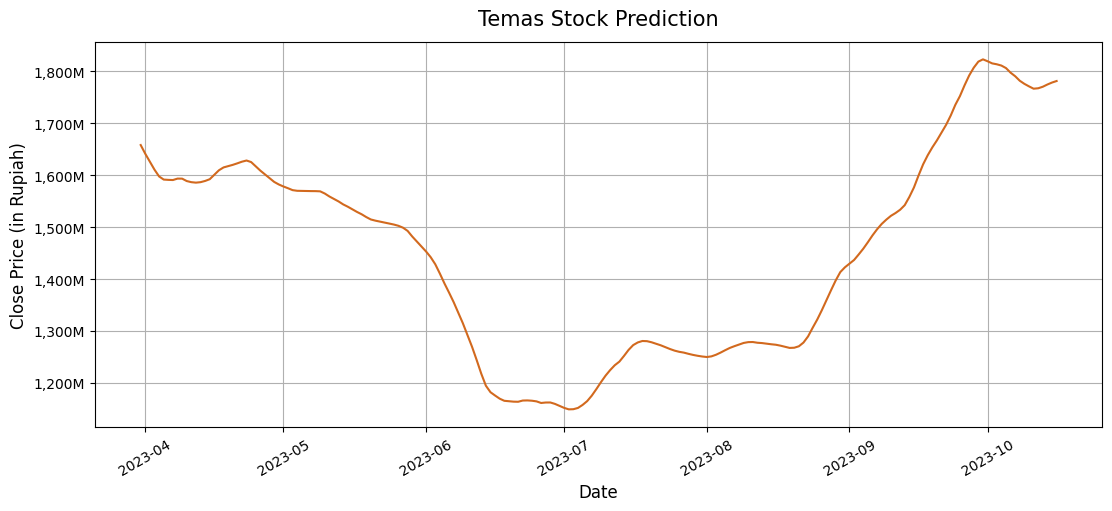

In [89]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [90]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 14s 285ms/step - loss: 0.0076 - val_loss: 0.0798
Epoch 2/10
24/24 [==============================] - 5s 208ms/step - loss: 0.0061 - val_loss: 0.0768
Epoch 3/10
24/24 [==============================] - 5s 230ms/step - loss: 0.0059 - val_loss: 0.0742
Epoch 4/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0056 - val_loss: 0.0726
Epoch 5/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0054 - val_loss: 0.0702
Epoch 6/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0052 - val_loss: 0.0672
Epoch 7/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0050 - val_loss: 0.0664
Epoch 8/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0048 - val_loss: 0.0644
Epoch 9/10
24/24 [==============================] - 5s 219ms/step - loss: 0.0046 - val_loss: 0.0616
Epoch 10/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0044 - val_loss: 0.060

In [91]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 1.2461414
Mean Absolute Percentage Error (MAPE): 0.803
Root Mean Squared Error (RMSE): 1.2751
Mean Squared Error (MSE): 1.6258883
R-Squared (R2): -18.123956
T-Statistic 0.9244
P-Value 1.1405864031033275e-09
Elapsed Time (min): 63.0


7/7 [==============================] - 0s 41ms/step


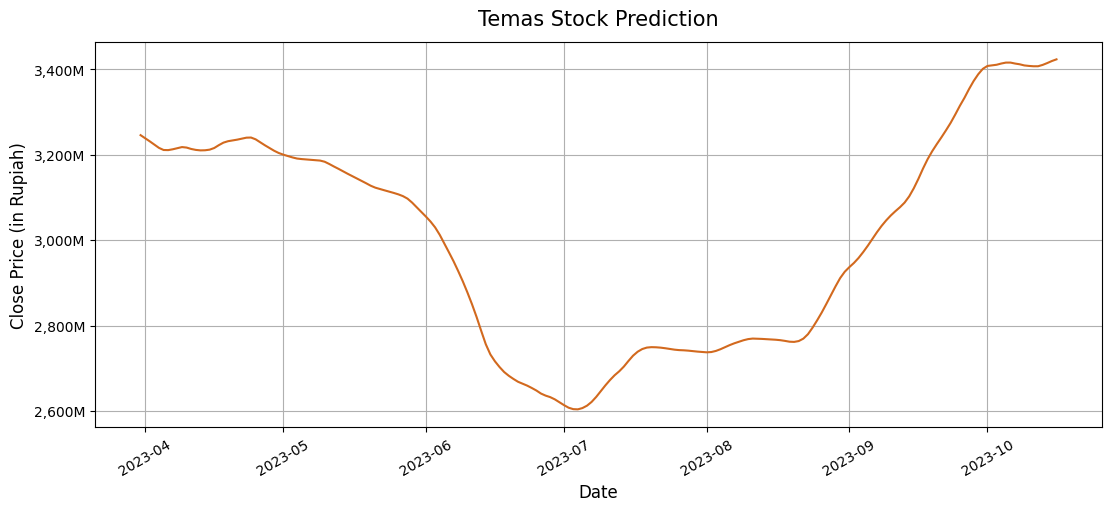

In [92]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [93]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/tmas_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 14s 278ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 2/10
24/24 [==============================] - 5s 203ms/step - loss: 2.5661e-04 - val_loss: 0.0071
Epoch 3/10
24/24 [==============================] - 5s 203ms/step - loss: 2.1486e-04 - val_loss: 0.0062
Epoch 4/10
24/24 [==============================] - 5s 208ms/step - loss: 1.8112e-04 - val_loss: 0.0059
Epoch 5/10
24/24 [==============================] - 5s 210ms/step - loss: 1.8017e-04 - val_loss: 0.0059
Epoch 6/10
24/24 [==============================] - 5s 209ms/step - loss: 1.6258e-04 - val_loss: 0.0057
Epoch 7/10
24/24 [==============================] - 5s 209ms/step - loss: 1.5771e-04 - val_loss: 0.0056
Epoch 8/10
24/24 [==============================] - 5s 226ms/step - loss: 1.6783e-04 - val_loss: 0.0054
Epoch 9/10
24/24 [==============================] - 5s 213ms/step - loss: 1.5814e-04 - val_loss: 0.0053
Epoch 10/10
24/24 [==============================] - 5s 228ms/step 

In [94]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.2017587
Mean Absolute Percentage Error (MAPE): 0.12199
Root Mean Squared Error (RMSE): 0.24703
Mean Squared Error (MSE): 0.0610237
R-Squared (R2): 0.282229
T-Statistic 0.9407
P-Value 3.134109860525314e-08
Elapsed Time (min): 60.99


7/7 [==============================] - 0s 36ms/step


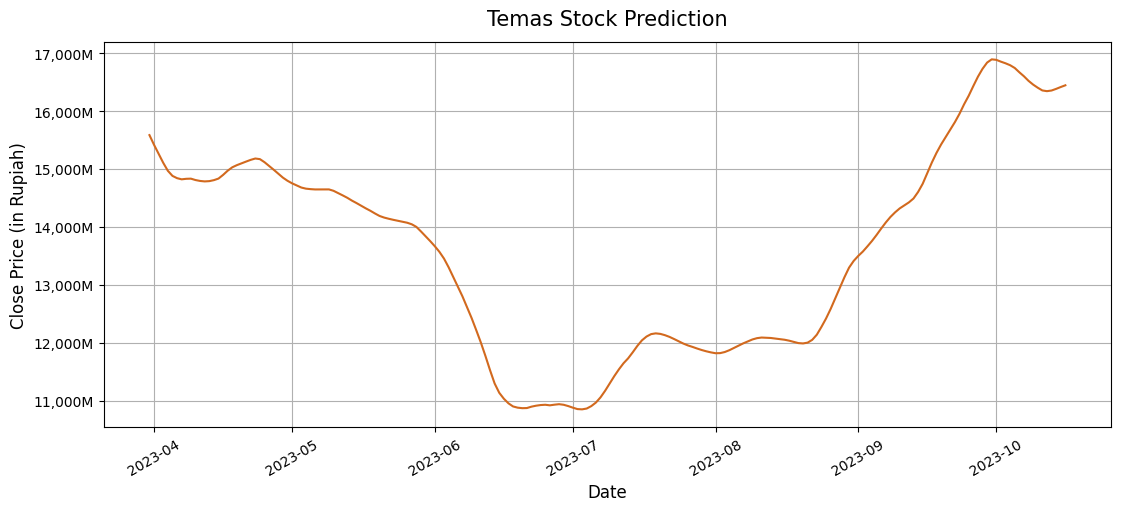

In [95]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_tmas.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='chocolate')
plt.title('Temas Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [96]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
import time
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 33ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 33ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 34ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 34ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 34ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 35ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 51ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 36ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 37ms/step
Training

In [97]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                80.46  1.22191   0.78848  1.55891   
           adagrad                 69.71  1.42429   0.92039  2.11094   
           adam                    56.92  0.14584   0.08951  0.03370   
           adamax                  76.94  0.10491   0.06529  0.02206   
           nadam                   83.84  0.18044   0.11179  0.04571   
           rmsprop                 77.25  0.25154   0.15283  0.08845   
           sgd                     78.72  1.04603   0.67249  1.15257   
relu       adadelta                70.15  1.40842   0.91137  2.05874   
           adagrad                 79.67  1.45721   0.94124  2.21161   
           adam                    80.43  0.23904   0.14916  0.07401   
           adamax                  71.48  0.29051   0.17863  0.11012   
           nadam                   85.76  0.16137   0.10008  0.03908   
           rmsprop                 71.65  0.57935   0.36041  0.39037   
           sgd                     79.06  1.21844   0.78512  1.55453   
sigmoid    adadelta                79.74  1.97567   1.28996  3.98811   
           adagrad                 78.04  1.39907   0.90364  2.03897   
           adam                    76.53  0.62607   0.38951  0.45451   
           adamax                  82.22  0.72654   0.45557  0.59557   
           nadam                   83.41  0.77386   0.48612  0.67183   
           rmsprop                 81.40  0.98659   0.62912  1.04492   
           sgd                     77.98  1.45647   0.94125  2.20707   
tanh       adadelta                83.36  1.48059   0.95808  2.27518   
           adagrad                 78.21  1.25038   0.80611  1.63527   
           adam                    73.63  0.22940   0.14054  0.07131   
           adamax                  78.62  0.17469   0.10576  0.04834   
           nadam                   83.35  0.27895   0.17398  0.09568   
           rmsprop                 78.89  0.44329   0.27262  0.24067   
           sgd                     85.60  1.22342   0.78866  1.56586   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   5.890856e-09         -17.34   1.24856     0.932806  
           adagrad    7.012148e-08         -23.83   1.45291     0.944360  
           adam       7.020653e-08           0.60   0.18358     0.944365  
           adamax     3.148850e-08           0.74   0.14853     0.940768  
           nadam      9.389574e-07           0.46   0.21380     0.955120  
           rmsprop    8.018894e-09          -0.04   0.29741     0.934317  
           sgd        5.501184e-09         -12.56   1.07358     0.932468  
relu       adadelta   3.949721e-08         -23.22   1.43483     0.941798  
           adagrad    1.490898e-10         -25.01   1.48715     0.913101  
           adam       6.148574e-08           0.13   0.27205     0.943779  
           adamax     3.010456e-08          -0.30   0.33184     0.940562  
           nadam      3.299007e-07           0.54   0.19769     0.950940  
           rmsprop    3.062271e-09          -3.59   0.62480     0.929531  
           sgd        4.072012e-09         -17.28   1.24681     0.930969  
sigmoid    adadelta   4.138241e-06         -45.91   1.99703     0.960701  
           adagrad    1.941482e-09         -22.98   1.42793     0.927192  
           adam       1.446387e-09          -4.35   0.67417     0.925655  
           adamax     1.331255e-09          -6.01   0.77173     0.925219  
           nadam      1.809085e-09          -6.90   0.81965     0.926825  
           rmsprop    5.961058e-09         -11.29   1.02221     0.932864  
           sgd        7.086270e-08         -24.96   1.48562     0.944406  
tanh       adadelta   2.555058e-06         -25.76   1.50837     0.958930  
           adagrad    3.800535e-09         -18.23   1.27878  

In [98]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adamax                  76.94  0.10491   0.06529  0.02206   
           adam                    56.92  0.14584   0.08951  0.03370   
relu       nadam                   85.76  0.16137   0.10008  0.03908   
tanh       adamax                  78.62  0.17469   0.10576  0.04834   
linear     nadam                   83.84  0.18044   0.11179  0.04571   
tanh       adam                    73.63  0.22940   0.14054  0.07131   
relu       adam                    80.43  0.23904   0.14916  0.07401   
linear     rmsprop                 77.25  0.25154   0.15283  0.08845   
tanh       nadam                   83.35  0.27895   0.17398  0.09568   
relu       adamax                  71.48  0.29051   0.17863  0.11012   
tanh       rmsprop                 78.89  0.44329   0.27262  0.24067   
relu       rmsprop                 71.65  0.57935   0.36041  0.39037   
sigmoid    adam                    76.53  0.62607   0.38951  0.45451   
           adamax                  82.22  0.72654   0.45557  0.59557   
           nadam                   83.41  0.77386   0.48612  0.67183   
           rmsprop                 81.40  0.98659   0.62912  1.04492   
linear     sgd                     78.72  1.04603   0.67249  1.15257   
relu       sgd                     79.06  1.21844   0.78512  1.55453   
linear     adadelta                80.46  1.22191   0.78848  1.55891   
tanh       sgd                     85.60  1.22342   0.78866  1.56586   
           adagrad                 78.21  1.25038   0.80611  1.63527   
sigmoid    adagrad                 78.04  1.39907   0.90364  2.03897   
relu       adadelta                70.15  1.40842   0.91137  2.05874   
linear     adagrad                 69.71  1.42429   0.92039  2.11094   
relu       adagrad                 79.67  1.45721   0.94124  2.21161   
sigmoid    sgd                     77.98  1.45647   0.94125  2.20707   
tanh       adadelta                83.36  1.48059   0.95808  2.27518   
sigmoid    adadelta                79.74  1.97567   1.28996  3.98811   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adamax     3.148850e-08           0.74   0.14853     0.940768  
           adam       7.020653e-08           0.60   0.18358     0.944365  
relu       nadam      3.299007e-07           0.54   0.19769     0.950940  
tanh       adamax     2.466361e-08           0.43   0.21986     0.939645  
linear     nadam      9.389574e-07           0.46   0.21380     0.955120  
tanh       adam       7.250411e-08           0.16   0.26704     0.944507  
relu       adam       6.148574e-08           0.13   0.27205     0.943779  
linear     rmsprop    8.018894e-09          -0.04   0.29741     0.934317  
tanh       nadam      1.815207e-06          -0.13   0.30932     0.957649  
relu       adamax     3.010456e-08          -0.30   0.33184     0.940562  
tanh       rmsprop    8.783545e-09          -1.83   0.49058     0.934759  
relu       rmsprop    3.062271e-09          -3.59   0.62480     0.929531  
sigmoid    adam       1.446387e-09          -4.35   0.67417     0.925655  
           adamax     1.331255e-09          -6.01   0.77173     0.925219  
           nadam      1.809085e-09          -6.90   0.81965     0.926825  
           rmsprop    5.961058e-09         -11.29   1.02221     0.932864  
linear     sgd        5.501184e-09         -12.56   1.07358     0.932468  
relu       sgd        4.072012e-09         -17.28   1.24681     0.930969  
linear     adadelta   5.890856e-09         -17.34   1.24856     0.932806  
tanh       sgd        8.802374e-09         -17.42   1.25134     0.934769  
           adagrad    3.800535e-09         -18.23   1.27878     0.930622  
sigmoid    adagrad    1.941482e-09         -22.98   1.42793     0.927192  
relu       adadelta   3.949721e-08         -23.22   1.43483  

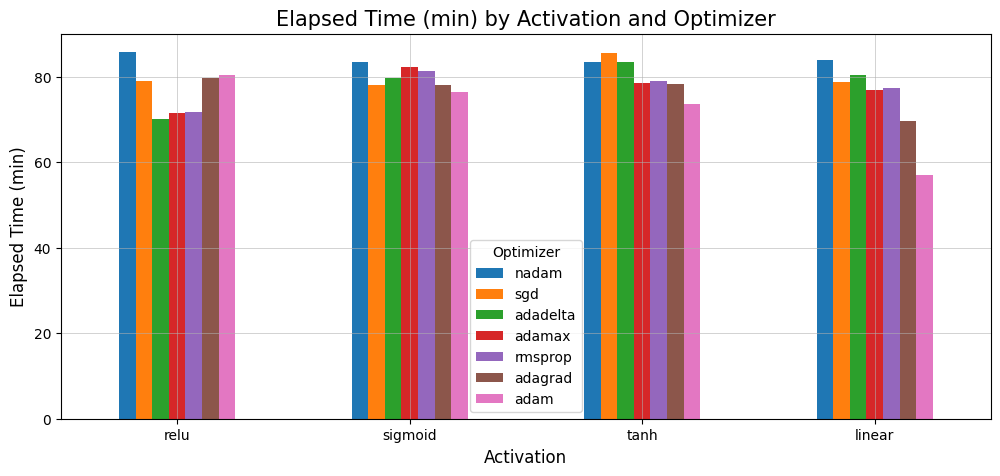

In [99]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

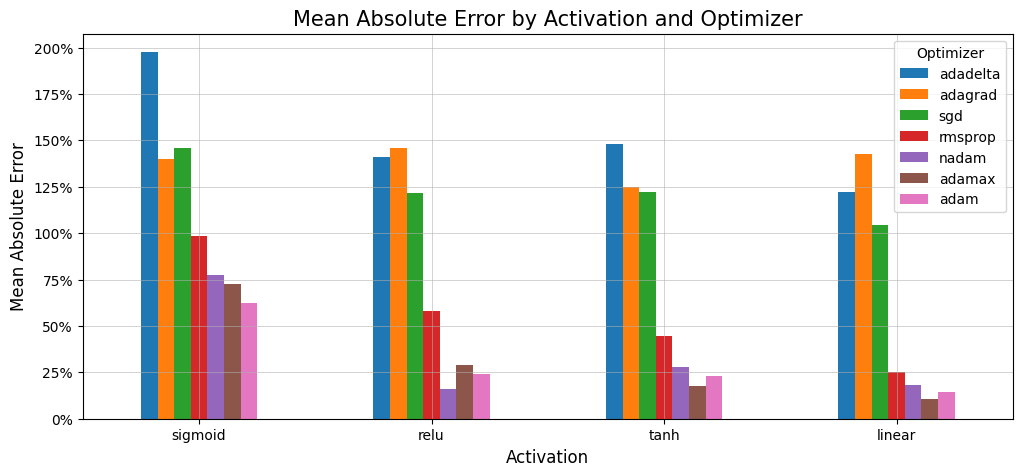

In [100]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

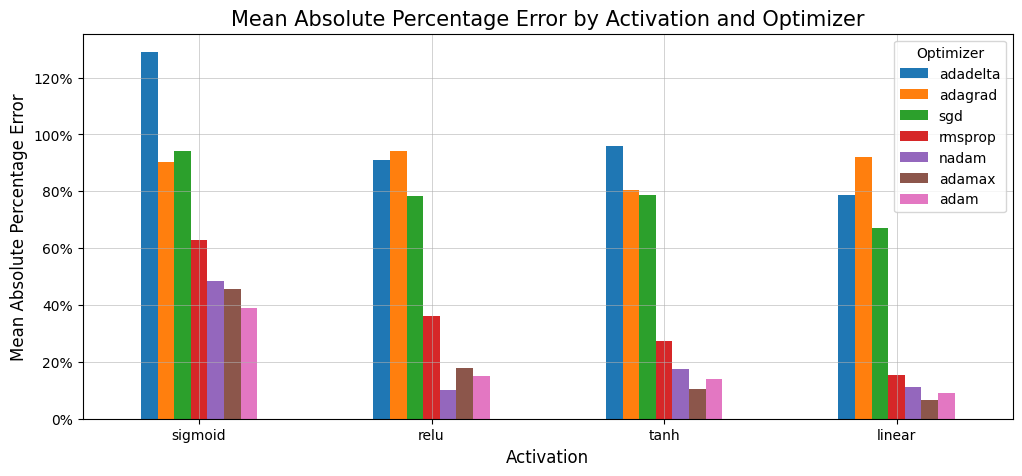

In [101]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

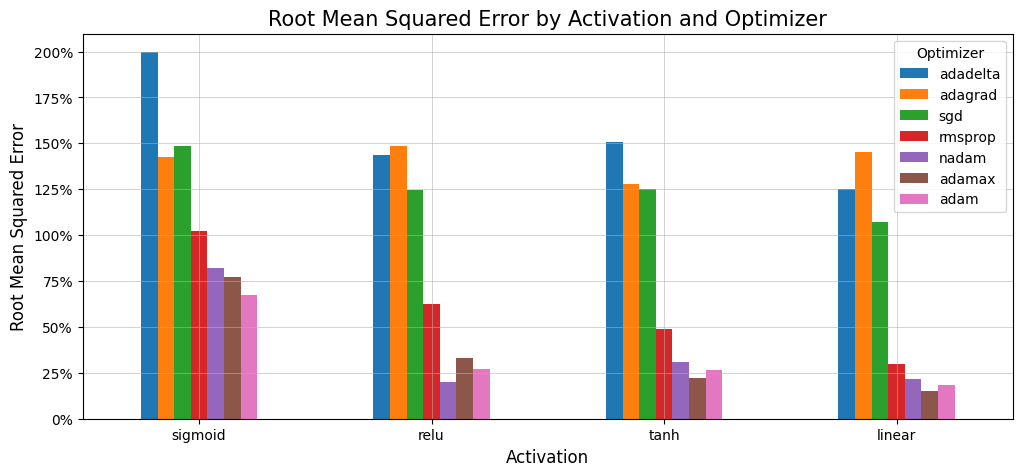

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

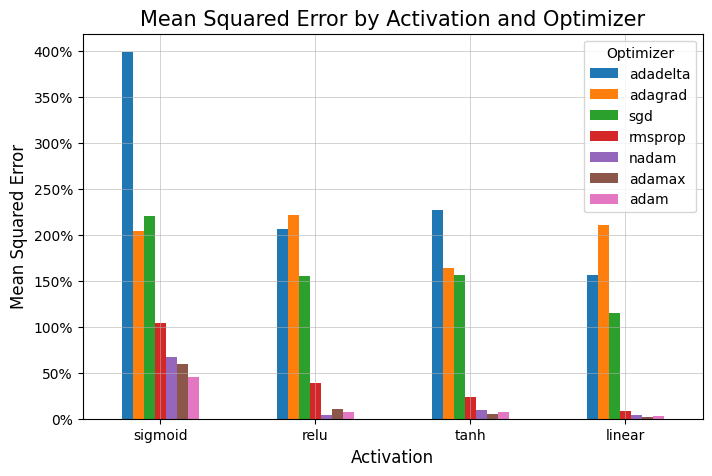

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

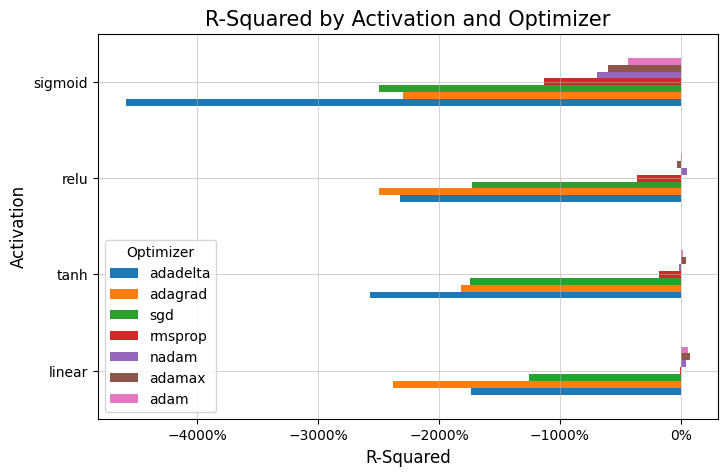

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()